<section id="back"> </section>

<nav style="margin-top: 20px; padding: 10px; background-color: #f0f0f0; border: 10px solid #ccc;">
    <div style="background-color:#2C41FF">
  <h2 style="margin: 0;text-align: center;">Table of Contents</h2>
    </div>
  <ul style="list-style: none; padding: 0;">
    <li style="margin: 5px 0;"><a href="#preSec" style="text-decoration: none; color: #333;">Problem statement </a></li>
    <li style="margin: 5px 0;"><a href="#sec1" style="text-decoration: none; color: #333;">Imports</a></li>
    <li style="margin: 5px 0;"><a href="#sec2" style="text-decoration: none; color: #333;">Data collection</a></li>
    <li style="margin: 5px 0;"><a href="#sec3" style="text-decoration: none; color: #333;">EDA</a></li>
    <li style="margin: 5px 0;"><a href="#sec4" style="text-decoration: none; color: #333;">Feature Engineering</a></li>
  </ul>
</nav>

<section id="preSec"> </section>

<!DOCTYPE html>
<html>
<head>
</head>
<body>
    <h2> 1 Problem statement</h2>
    This project analyzes children's physical activity and fitness data to identify early signs of problematic internet use
</body>
</html>

<section id="sec1"> </section>
<h2> 2 Import Data and Required Packages </h2>

<a href="#back" style="text-decoration: none; color: #333;">Back to table of contents</a>

In [ ]:
# !pip install skimpy --quiet
# !pip install wordcloud --quiet
# !pip install category_encoders --quiet
# !pip install shap

# Basic imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
#import skimpy
import re
import time
import random
import datetime
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="Parameters: { 'verbose' } are not used.")

##################### Preprocessing imports 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor
from sklearn.inspection import permutation_importance
from sklearn.base import clone

##################### Models
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

##################### optuna library import
import optuna
import shap
random_state = 42


#!pip install opendatasets

c:\Users\Nadav\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<h2>2.1 Data collection</h2>

In [ ]:
######## Download the data 
train=pd.read_csv("../data/raw/train.csv")
test=pd.read_csv("../data/raw/test.csv")
data_dict=pd.read_csv("../data/raw/data_dictionary.csv")
sample_sub=pd.read_csv("../data/raw/sample_submission.csv")

<section id="preSec"> </section>

<!DOCTYPE html>
<html>
<head>
</head>
<body>
    <h3 align="center"> Dataset Instruments Information </h3>
    <table>
      <tr>
        <th>Instrument Name</th>
        <th>Explanation</th>
      </tr>
      <tr>
        <td>Demographics</td>
        <td>Information about age and sex of participants.</td>
      </tr>
      <tr>
        <td>Internet Use</td>
        <td>Number of hours of using computer/internet per day.</td>
      </tr>
      <tr>
        <td>Children's Global Assessment Scale</td>
        <td>Numeric scale used by mental health clinicians to rate the general functioning of youths under the age of 18.</td>
      </tr>
      <tr>
        <td>Physical Measures</td>
        <td>Collection of blood pressure, heart rate, height, weight and waist, and hip measurements.</td>
      </tr>
      <tr>
        <td>FitnessGram Vitals and Treadmill</td>
        <td>Measurements of cardiovascular fitness assessed using the NHANES treadmill protocol.</td>
      </tr>
      <tr>
        <td>FitnessGram Child</td>
        <td>Health related physical fitness assessment measuring five different parameters including aerobic capacity, muscular strength, muscular endurance, flexibility, and body composition.</td>
      </tr>
      <tr>
        <td>Bio-electric Impedance Analysis</td>
        <td>Measure of key body composition elements, including BMI, fat, muscle, and water content.</td>
      </tr>
      <tr>
        <td>Physical Activity Questionnaire</td>
        <td>Information about children's participation in vigorous activities over the last 7 days.</td>
      </tr>
      <tr>
        <td>Sleep Disturbance Scale</td>
        <td>Scale to categorize sleep disorders in children.</td>
      </tr>
      <tr>
        <td>Actigraphy</td>
        <td>Objective measure of ecological physical activity through a research-grade biotracker.</td>
      </tr>
      <tr>
        <td>Parent-Child Internet Addiction Test </td>
        <td>20-item scale that measures characteristics and behaviors associated with compulsive use of the Internet including compulsivity, escapism, and dependency.</td>
      </tr>
    </table>
    <br>
    <p><b>Special Note - <br></b>
    Note in particular the field PCIAT-PCIAT_Total. The   target sii for this competition is derived from this field as described in the data dictionary: 0 for None, 1 for Mild, 2 for Moderate, and 3 for Severe. Additionally, each participant has been assigned a unique identifier id.</p>
 
</body>
</html>

<h3> Basic configuration </h3>
<li>Map sii - map the target column in order to make the target data more clear</li>
<li>perform basic actions - such as dropping the id column across the datasets and applying the map for the dataset</li>

In [ ]:
def map_sii(train):  
    # Map definitions
    sii_map = {
        0: "None",
        1: "Mild",
        2: "Moderate",
        3: "Severe",
        "missing": "Missing Data"
    }

    mapped_df = train.copy()
    # Replace NaN values with "missing" to count them as a separate category
    mapped_df['sii_filled'] = mapped_df['sii'].fillna("missing")
    mapped_df['sii_label'] = mapped_df['sii_filled'].map(sii_map)
    return mapped_df

In [ ]:
try:
    # Define Dependent and Target feature 
    target = 'sii'
    Target_series = train['sii']
    
    # Drop the id column from all dataset respectively 
    train.drop(['id'], axis =1, inplace = True)
    test.drop(['id'], axis =1, inplace = True)
    data_dict = data_dict[data_dict['Field'].str.contains('id') == False]
    
    # Create a copy 
    train_copy = train.copy()
    
    # map the sii (target column)
    mapped_df = map_sii(train)
    
except:
    print("Already dropped id or name column")
    

<h3>Basic Data Checks to perform</h3>
<ul>
    <li>Check Missing values</li>
    <li>Check Duplicates</li>
    <li>Check data type</li>
    <li>Check statistics of data set</li>
    <li>Check difference between train and test</li>
</ul>

In [ ]:
def summary(train):
    sum = pd.DataFrame(train.dtypes, columns=['dtypes'])
    sum['missing#'] = train.isna().sum()
    sum['missing%'] = (train.isna().sum())/len(train)
    sum['uniques'] = train.nunique().values
    sum['count'] = train.count().values
    display(train.head(1))
    return sum

In [ ]:
display(summary(data_dict).style.background_gradient(cmap='Blues'))
display(summary(train).style.background_gradient(cmap='Blues'))

Instrument                      Field           Description Type  \
1  Demographics  Basic_Demos-Enroll_Season  Season of enrollment  str   

                         Values Value Labels  
1  Spring, Summer, Fall, Winter          NaN

Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex CGAS-Season  \
0                      Fall                5                0      Winter   

   CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0             51.0            Fall     16.877316             46.0   

   Physical-Weight  Physical-Waist_Circumference  ...  PCIAT-PCIAT_18  \
0             50.8                           NaN  ...             4.0   

   PCIAT-PCIAT_19  PCIAT-PCIAT_20 PCIAT-PCIAT_Total  SDS-Season  \
0             2.0             4.0              55.0         NaN   

   SDS-SDS_Total_Raw  SDS-SDS_Total_T PreInt_EduHx-Season  \
0                NaN              NaN                Fall   

   PreInt_EduHx-computerinternet_hoursday  sii  
0                                     3.0  2.0  

[1 rows x 81 columns]

In [ ]:
train.describe(include='object')

Basic_Demos-Enroll_Season CGAS-Season Physical-Season  \
count                       3960        2555            3310   
unique                         4           4               4   
top                       Spring      Spring          Spring   
freq                        1127         697             929   

       Fitness_Endurance-Season FGC-Season BIA-Season PAQ_A-Season  \
count                      1308       3346       2145          475   
unique                        4          4          4            4   
top                      Spring     Spring     Summer       Winter   
freq                        385        993        669          137   

       PAQ_C-Season PCIAT-Season SDS-Season PreInt_EduHx-Season  
count          1721         2736       2618                3540  
unique            4            4          4                   4  
top          Spring       Spring     Spring              Spring  
freq            506          762        712                 985

<h3> 3.1 Check missing values</h3>

<Axes: >

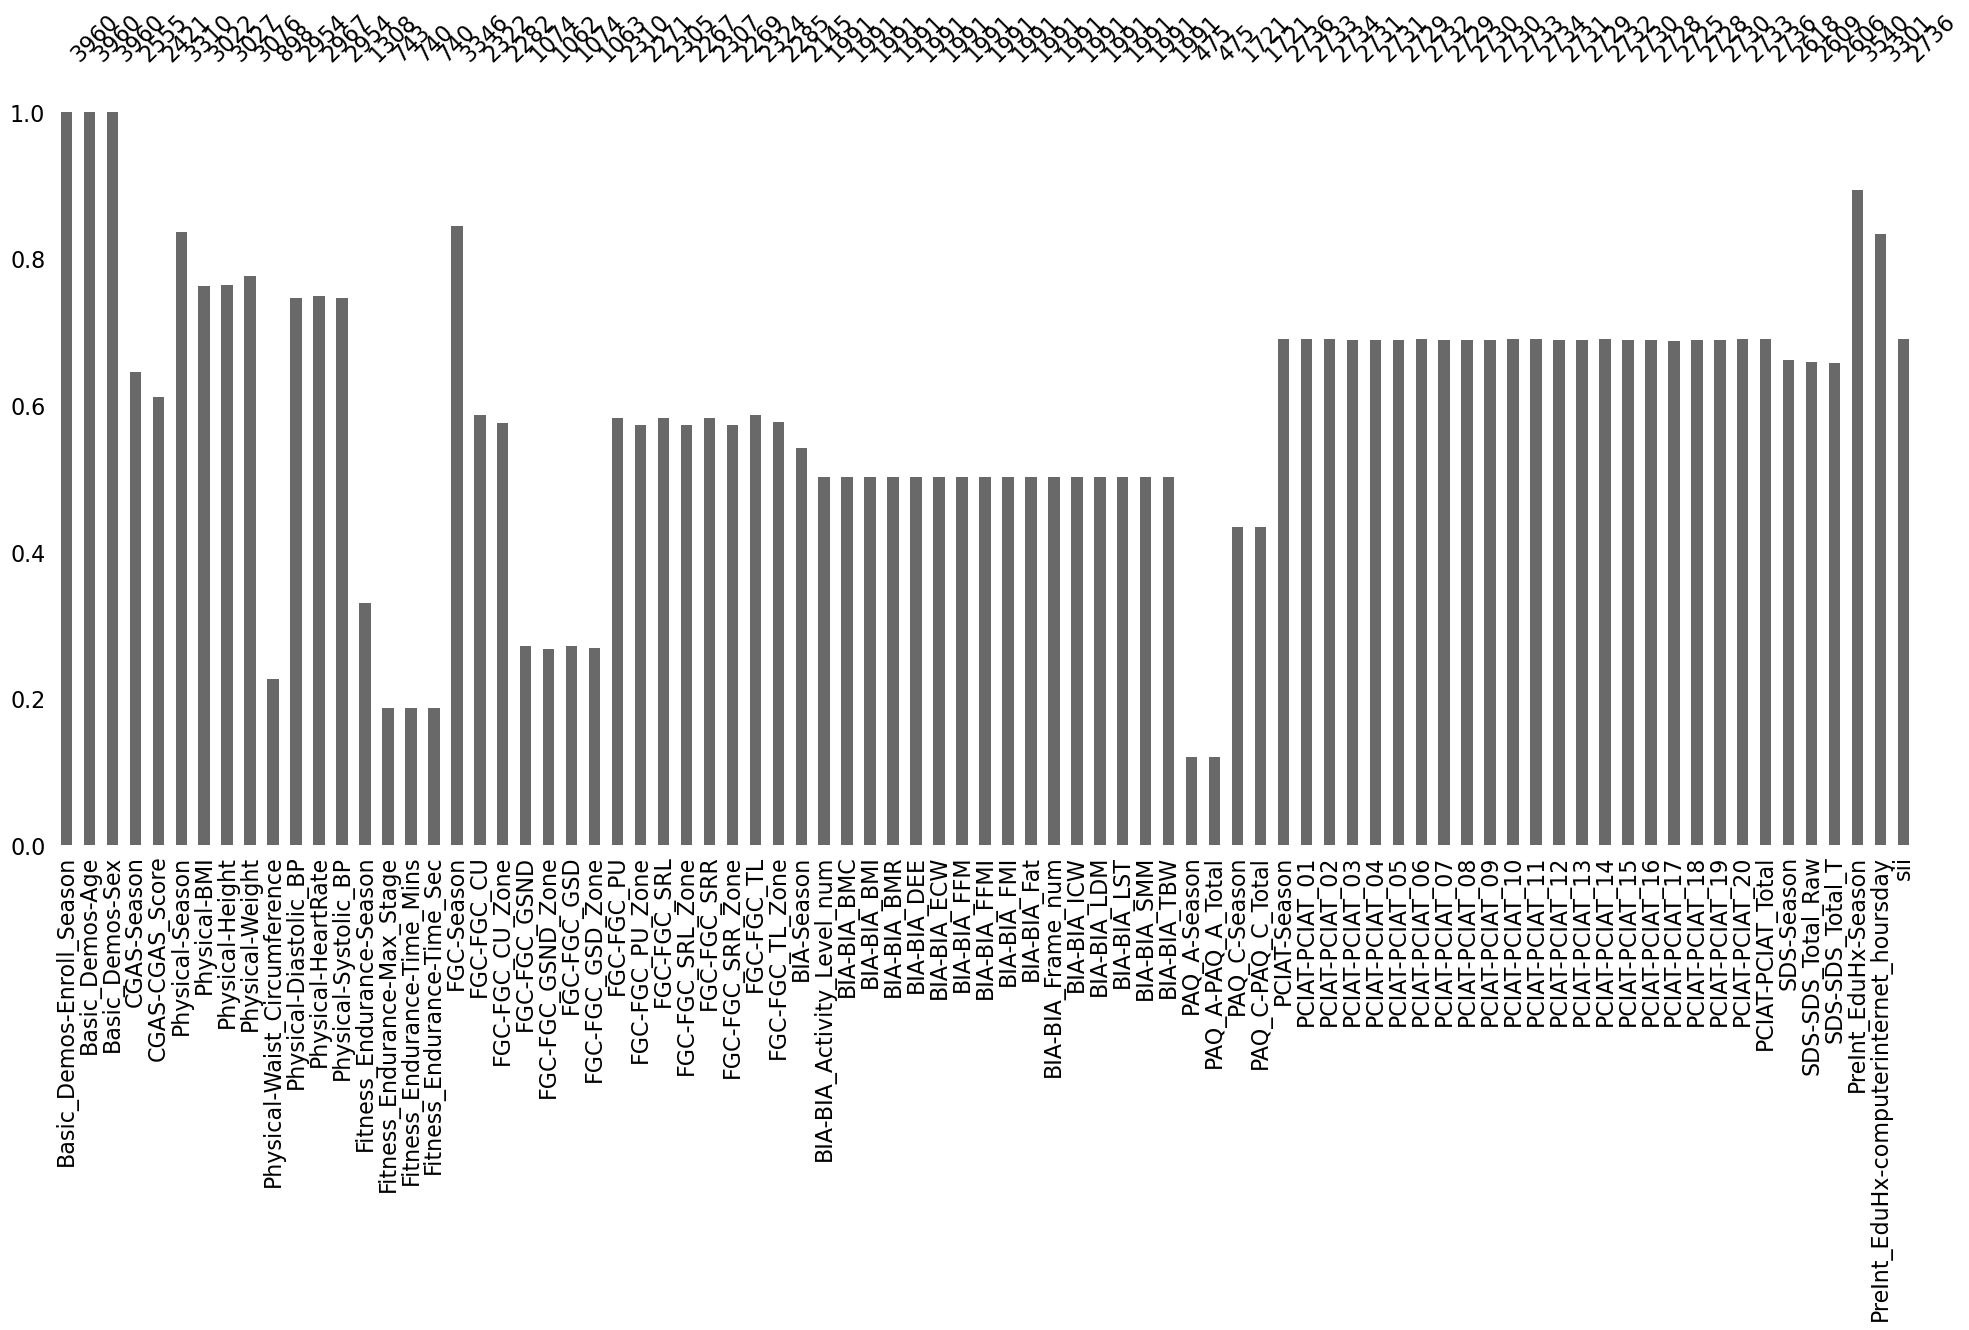

In [ ]:
import missingno as msno 
# Visualize missing values as a matrix 
msno.bar(train) 

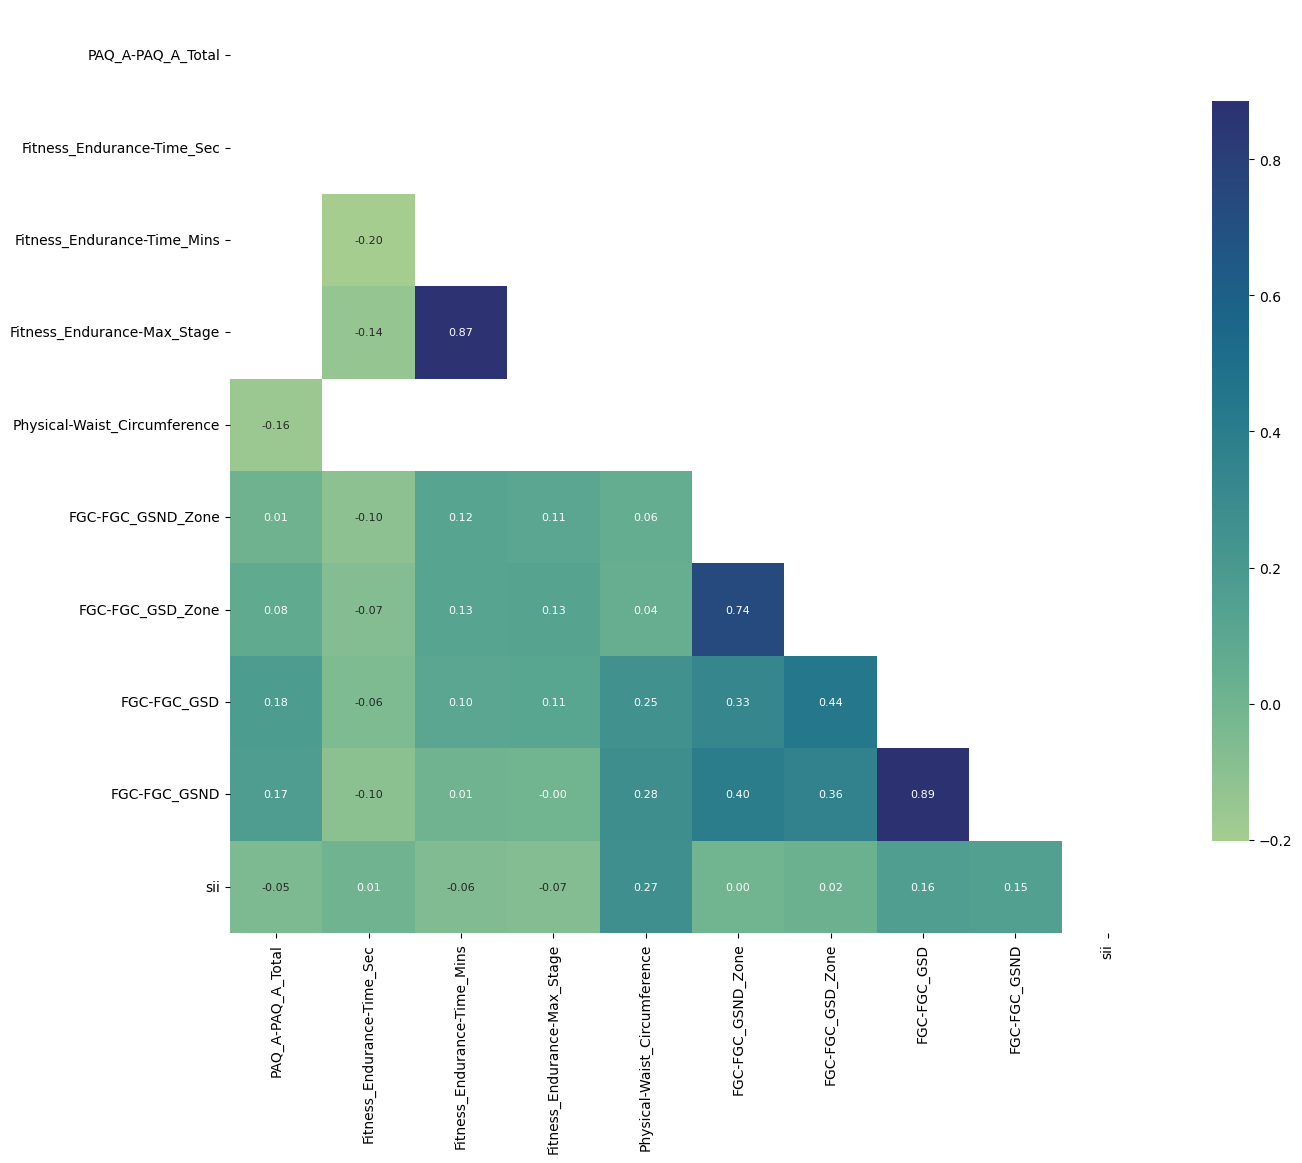

In [ ]:
# Checking correlation of highly missing features to the target (The function itself is below)
missing_percentages = train.isna().sum() / len(train)
top_10_missing = missing_percentages.sort_values(ascending=False).head(10)
top_10_df = train[top_10_missing.index]

top_11_df = concat_df_a_target(top_10_df,Target_series)
correlation(top_11_df)

<h4>Insights</h4>
It can be seen that most of the features with heavily missing values aer not significantly correlated with the sii score (which is the target). That means that we will be able to remove them without hurting our score

<h3> Missing values in target<h3>

In [ ]:
def drop_Nans(train,subset):
    dropped_df = train.dropna(subset=subset).reset_index().drop('index',axis=1)
    return dropped_df
# hello = drop_Nans(train,Target_series.name)

<h3> 3.2 Check Duplicates </h3>

In [ ]:
# Duplicated rows
display(train.duplicated().sum())
display(train[train.duplicated()].head())

137

Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex CGAS-Season  \
213                    Spring               11                0         NaN   
314                    Summer                7                0         NaN   
452                    Summer                8                1         NaN   
623                    Summer                7                0         NaN   
696                    Summer                8                1         NaN   

     CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
213              NaN             NaN           NaN              NaN   
314              NaN             NaN           NaN              NaN   
452              NaN             NaN           NaN              NaN   
623              NaN             NaN           NaN              NaN   
696              NaN             NaN           NaN              NaN   

     Physical-Weight  Physical-Waist_Circumference  ...  PCIAT-PCIAT_18  \
213              NaN                           NaN  ...             NaN   
314              NaN                           NaN  ...             NaN   
452              NaN                           NaN  ...             NaN   
623              NaN                           NaN  ...             NaN   
696              NaN                           NaN  ...             NaN   

     PCIAT-PCIAT_19  PCIAT-PCIAT_20 PCIAT-PCIAT_Total  SDS-Season  \
213             NaN             NaN               NaN         NaN   
314             NaN             NaN               NaN         NaN   
452             NaN             NaN               NaN         NaN   
623             NaN             NaN               NaN         NaN   
696             NaN             NaN               NaN         NaN   

     SDS-SDS_Total_Raw  SDS-SDS_Total_T PreInt_EduHx-Season  \
213                NaN              NaN                 NaN   
314                NaN              NaN                 NaN   
452                NaN              NaN                 NaN   
623                NaN              NaN                 NaN   
696                NaN              NaN                 NaN   

     PreInt_EduHx-computerinternet_hoursday  sii  
213                                     NaN  NaN  
314                                     NaN  NaN  
452                                     NaN  NaN  
623                                     NaN  NaN  
696                                     NaN  NaN  

[5 rows x 81 columns]

<h3> 3.3 Check data types </h3>

In [ ]:
# Feature data types 
column_types = train.dtypes.value_counts()
pd.DataFrame({'Count': column_types})

Count
float64     68
object      11
int64        2

<h3>First Insights</h3>
Like specified before, there are a lot of missing information. 
<ul>
    <li style="margin: 5px 0;">The percentage of missing data varies between 10% up to 88%. </li>
    <li style="margin: 5px 0;">
The sii score index which is the predictive feature have a 30% missing data
    </li>
    <li style="margin: 5px 0;">Majority of the data is Numerical</li>
    <li style="margin: 5px 0;">There are 137 duplicated rows which are about 3% of the data</li>
Conclusions, insepct column with high percentage of missing values
  </ul>


<h3>3.4 Check statistics of data set</h3>

In [ ]:
# I am splitting the data to different dataframes based on the Instrument category 
# in order to ease EDA and feature engineering
# Each dataframe contains all the fields 

def split_to_dataframes(data,dict_data,split_category,feature_list_column):
     # Dictionary to hold each split DataFrame
    split_dfs = {}
    
    # split
    categories = dict_data[split_category].unique()

    for category in categories:
        cols=dict_data[dict_data[split_category].values == category][feature_list_column].values
        # Store the subset in the dictionary with the category as the key
        split_dfs[category] = data[cols]
        
    return split_dfs

def clean_df_name(df):
  
    #rename csv, force lower case, no spaces, no dashes
    clean_df_name = df.lower().replace(" ", "_").replace("-","_").replace(r"/","_").replace("\\","_").replace("$","").replace("%","").replace("'", "").replace("(", "").replace(")", "")
    
    df_name = '{0}'.format(clean_df_name.split('.')[0])

    return df_name

def create_new_dataframes(split_dfs):
    '''get dict of dataframes and creates new dataframes for each'''
    dataframes_names=[]
    for key, df in split_dfs.items():
        df_key = 'Df_' + key 
        df_key = clean_df_name(df_key)

        split_dfs[df_key] = split_dfs.pop(key)
        dataframes_names.append(df_key) 

        # Defind new data frame
        new_df_name = df_key

        # Use globals() to create a new variable in the global namespace
        globals()[new_df_name] = df.copy()

        #display(globals()[new_df_name].head())  # Print the first few rows of the new DataFrame
      
    return dataframes_names

def concat_df_a_target(df,target):
    return pd.concat([df,target], axis=1)

In [ ]:
# Split to dataframes and alter names
split_dfs = split_to_dataframes(train,data_dict,'Instrument','Field') 
lists = create_new_dataframes(split_dfs)
lists

['df_demographics',
 'df_childrens_global_assessment_scale',
 'df_physical_measures',
 'df_fitnessgram_vitals_and_treadmill',
 'df_fitnessgram_child',
 'df_bio_electric_impedance_analysis',
 'df_physical_activity_questionnaire_adolescents',
 'df_physical_activity_questionnaire_children',
 'df_parent_child_internet_addiction_test',
 'df_sleep_disturbance_scale',
 'df_internet_use']

In [ ]:
for key, df in split_dfs.items():
    display(df.describe())

Basic_Demos-Age  Basic_Demos-Sex
count      3960.000000      3960.000000
mean         10.426894         0.372727
std           3.554845         0.483591
min           5.000000         0.000000
25%           8.000000         0.000000
50%          10.000000         0.000000
75%          13.000000         1.000000
max          20.500000         1.000000

CGAS-CGAS_Score
count      2421.000000
mean         65.454771
std          22.341862
min          25.000000
25%          59.000000
50%          65.000000
75%          75.000000
max         999.000000

Physical-BMI  Physical-Height  Physical-Weight  \
count   3022.000000      3027.000000      3076.000000   
mean      19.331929        55.946713        89.038615   
std        5.113934         7.473764        44.569040   
min        0.000000        33.000000         0.000000   
25%       15.869350        50.000000        57.200000   
50%       17.937682        55.000000        77.000000   
75%       21.571244        62.000000       113.800000   
max       59.132048        78.500000       315.000000   

       Physical-Waist_Circumference  Physical-Diastolic_BP  \
count                    898.000000            2954.000000   
mean                      27.278508              69.648951   
std                        5.567287              13.611226   
min                       18.000000               0.000000   
25%                       23.000000              61.000000   
50%                       26.000000              68.000000   
75%                       30.000000              76.000000   
max                       50.000000             179.000000   

       Physical-HeartRate  Physical-Systolic_BP  
count         2967.000000           2954.000000  
mean            81.597236            116.983074  
std             13.665196             17.061225  
min             27.000000              0.000000  
25%             72.000000            107.000000  
50%             81.000000            114.000000  
75%             90.500000            125.000000  
max            138.000000            203.000000

Fitness_Endurance-Max_Stage  Fitness_Endurance-Time_Mins  \
count                   743.000000                   740.000000   
mean                      4.989233                     7.370270   
std                       2.014072                     3.189662   
min                       0.000000                     0.000000   
25%                       4.000000                     6.000000   
50%                       5.000000                     7.000000   
75%                       6.000000                     9.000000   
max                      28.000000                    20.000000   

       Fitness_Endurance-Time_Sec  
count                  740.000000  
mean                    27.581081  
std                     17.707751  
min                      0.000000  
25%                     12.750000  
50%                     28.000000  
75%                     43.000000  
max                     59.000000

FGC-FGC_CU  FGC-FGC_CU_Zone  FGC-FGC_GSND  FGC-FGC_GSND_Zone  \
count  2322.000000      2282.000000   1074.000000        1062.000000   
mean     11.259690         0.476337     22.420438           1.829567   
std      11.807781         0.499549     10.833995           0.612585   
min       0.000000         0.000000      0.000000           1.000000   
25%       3.000000         0.000000     15.100000           1.000000   
50%       9.000000         0.000000     20.050000           2.000000   
75%      15.750000         1.000000     26.600000           2.000000   
max     115.000000         1.000000    124.000000           3.000000   

       FGC-FGC_GSD  FGC-FGC_GSD_Zone   FGC-FGC_PU  FGC-FGC_PU_Zone  \
count  1074.000000       1063.000000  2310.000000      2271.000000   
mean     23.518622          1.904045     5.579654         0.330251   
std      11.148951          0.612344     7.390161         0.470407   
min       0.000000          1.000000     0.000000         0.000000   
25%      16.200000          2.000000     0.000000         0.000000   
50%      21.200000          2.000000     3.000000         0.000000   
75%      28.175000          2.000000     9.000000         1.000000   
max     123.800000          3.000000    51.000000         1.000000   

       FGC-FGC_SRL  FGC-FGC_SRL_Zone  FGC-FGC_SRR  FGC-FGC_SRR_Zone  \
count  2305.000000       2267.000000  2307.000000       2269.000000   
mean      8.694924          0.618880     8.805635          0.620097   
std       3.429301          0.485769     3.422167          0.485469   
min       0.000000          0.000000     0.000000          0.000000   
25%       7.000000          0.000000     7.000000          0.000000   
50%       9.000000          1.000000     9.000000          1.000000   
75%      11.000000          1.000000    11.000000          1.000000   
max      21.700000          1.000000    21.000000          1.000000   

        FGC-FGC_TL  FGC-FGC_TL_Zone  
count  2324.000000      2285.000000  
mean      9.252775         0.785558  
std       2.988863         0.410525  
min       0.000000         0.000000  
25%       7.000000         1.000000  
50%      10.000000         1.000000  
75%      12.000000         1.000000  
max      22.000000         1.000000

BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI   BIA-BIA_BMR  \
count                 1991.000000  1991.000000  1991.000000   1991.000000   
mean                     2.651431     6.719826    19.367048   1237.018187   
std                      1.028267    92.586325     5.047848   1872.383246   
min                      1.000000    -7.789610     0.048267    813.397000   
25%                      2.000000     2.966905    15.913600   1004.710000   
50%                      3.000000     3.922720    17.966500   1115.380000   
75%                      3.000000     5.460925    21.461100   1310.360000   
max                      5.000000  4115.360000    53.924300  83152.200000   

         BIA-BIA_DEE  BIA-BIA_ECW  BIA-BIA_FFM  BIA-BIA_FFMI  BIA-BIA_FMI  \
count    1991.000000  1991.000000  1991.000000   1991.000000  1991.000000   
mean     2064.693747    20.825346    74.021708     15.030554     4.336495   
std      2836.246272    73.266287   199.433753      5.792505     6.356402   
min      1073.450000     1.789450    28.900400      7.864850  -194.163000   
25%      1605.785000    11.109550    49.278100     13.408000     2.306915   
50%      1863.980000    15.928000    61.066200     14.092500     3.698630   
75%      2218.145000    25.162200    81.833800     15.430950     5.987690   
max    124728.000000  3233.000000  8799.080000    217.771000    28.251500   

       BIA-BIA_Fat  BIA-BIA_Frame_num  BIA-BIA_ICW  BIA-BIA_LDM  BIA-BIA_LST  \
count  1991.000000        1991.000000  1991.000000   1991.00000  1991.000000   
mean     16.855020           1.745354    33.173380     20.02299    67.301883   
std     199.372119           0.680635    56.272346     70.21561   108.705918   
min   -8745.080000           1.000000    14.489000      4.63581    23.620100   
25%       8.602395           1.000000    24.463500     12.98315    45.204100   
50%      16.174600           2.000000    28.855800     16.43880    56.996400   
75%      30.273100           2.000000    35.475700     22.16760    77.105650   
max     153.820000           3.000000  2457.910000   3108.17000  4683.710000   

       BIA-BIA_SMM  BIA-BIA_TBW  
count  1991.000000  1991.000000  
mean     34.389466    53.998726  
std      84.050607   129.362539  
min       4.655730    20.589200  
25%      21.141550    35.887000  
50%      27.415100    44.987000  
75%      38.179400    60.271050  
max    3607.690000  5690.910000

PAQ_A-PAQ_A_Total
count         475.000000
mean            2.178853
std             0.849476
min             0.660000
25%             1.490000
50%             2.010000
75%             2.780000
max             4.710000

PAQ_C-PAQ_C_Total
count        1721.000000
mean            2.589550
std             0.783937
min             0.580000
25%             2.020000
50%             2.540000
75%             3.160000
max             4.790000

PCIAT-PCIAT_01  PCIAT-PCIAT_02  PCIAT-PCIAT_03  PCIAT-PCIAT_04  \
count     2733.000000     2734.000000     2731.000000     2731.000000   
mean         2.370655        2.177762        2.399854        0.839253   
std          1.673312        1.697117        1.588807        1.195601   
min          0.000000        0.000000        0.000000        0.000000   
25%          1.000000        1.000000        1.000000        0.000000   
50%          2.000000        2.000000        2.000000        0.000000   
75%          4.000000        4.000000        4.000000        1.000000   
max          5.000000        5.000000        5.000000        5.000000   

       PCIAT-PCIAT_05  PCIAT-PCIAT_06  PCIAT-PCIAT_07  PCIAT-PCIAT_08  \
count     2729.000000     2732.000000     2729.000000     2730.000000   
mean         2.297545        1.063690        0.586295        1.246520   
std          1.705218        1.268282        1.049355        1.342582   
min          0.000000        0.000000        0.000000        0.000000   
25%          1.000000        0.000000        0.000000        0.000000   
50%          2.000000        1.000000        0.000000        1.000000   
75%          4.000000        2.000000        1.000000        2.000000   
max          5.000000        5.000000        5.000000        5.000000   

       PCIAT-PCIAT_09  PCIAT-PCIAT_10  ...  PCIAT-PCIAT_12  PCIAT-PCIAT_13  \
count     2730.000000     2733.000000  ...     2731.000000     2729.000000   
mean         1.062637        1.304793  ...        0.244599        1.340051   
std          1.258797        1.331715  ...        0.522956        1.411156   
min          0.000000        0.000000  ...        0.000000        0.000000   
25%          0.000000        0.000000  ...        0.000000        0.000000   
50%          1.000000        1.000000  ...        0.000000        1.000000   
75%          2.000000        2.000000  ...        0.000000        2.000000   
max          5.000000        5.000000  ...        5.000000        5.000000   

       PCIAT-PCIAT_14  PCIAT-PCIAT_15  PCIAT-PCIAT_16  PCIAT-PCIAT_17  \
count     2732.000000     2730.000000     2728.000000     2725.000000   
mean         1.035505        1.499634        1.452346        1.627890   
std          1.301712        1.492929        1.495600        1.445622   
min          0.000000        0.000000        0.000000        0.000000   
25%          0.000000        0.000000        0.000000        0.000000   
50%          1.000000        1.000000        1.000000        1.000000   
75%          2.000000        2.000000        2.000000        3.000000   
max          5.000000        5.000000        5.000000        5.000000   

       PCIAT-PCIAT_18  PCIAT-PCIAT_19  PCIAT-PCIAT_20  PCIAT-PCIAT_Total  
count     2728.000000     2730.000000     2733.000000        2736.000000  
mean         1.613636        1.158974        0.943652          27.896199  
std          1.529178        1.343661        1.185460          20.338853  
min          0.000000        0.000000        0.000000           0.000000  
25%          0.000000        0.000000        0.000000          12.000000  
50%          1.000000        1.000000        1.000000          26.000000  
75%          2.000000        2.000000        1.000000          41.000000  
max          5.000000        5.000000        5.000000          93.000000  

[8 rows x 21 columns]

SDS-SDS_Total_Raw  SDS-SDS_Total_T
count        2609.000000      2606.000000
mean           41.088923        57.763622
std            10.427433        13.196091
min            17.000000        38.000000
25%            33.000000        47.000000
50%            39.000000        55.000000
75%            46.000000        64.000000
max            96.000000       100.000000

PreInt_EduHx-computerinternet_hoursday
count                             3301.000000
mean                                 1.060588
std                                  1.094875
min                                  0.000000
25%                                  0.000000
50%                                  1.000000
75%                                  2.000000
max                                  3.000000

Split to dataframes
In order to make sense of the large scaled dataframe I choose to split it to multiple and investigate 

<h3>3.5 Difference between train and test</h3>
I found out that in the test set the features about the parents test are missing.

In [ ]:
def feature_difference(train, test):
    # Get the set of column names from each DataFrame
    train_set = set(train.columns)
    test_set = set(test.columns)

    # find the difference in cols
    feature_difference_cols = train_set - test_set

    return feature_difference_cols

<h4>Datasets - PCIAT</h4>
<p>
This dataset is a 20 questions test that the parents have to answer, the values are on a scale between 0 and 5. In all of the question there are about the same number of missing values (between 2736 to 2725). If we remove all Rows with Nans we get 2671. 
The last feature is the overall score of the test (which is of course between 0 to a 100).</p>
<br>
Those features of this dataset doesn't appaer in test set (because the sii which is the predictive metric is derived by them

In [ ]:
PCIAT = concat_df_a_target(df_parent_child_internet_addiction_test,Target_series)
PCIAT

PCIAT-Season  PCIAT-PCIAT_01  PCIAT-PCIAT_02  PCIAT-PCIAT_03  \
0            Fall             5.0             4.0             4.0   
1            Fall             0.0             0.0             0.0   
2            Fall             5.0             2.0             2.0   
3          Summer             4.0             2.0             4.0   
4             NaN             NaN             NaN             NaN   
...           ...             ...             ...             ...   
3955       Winter             3.0             3.0             3.0   
3956          NaN             NaN             NaN             NaN   
3957       Winter             5.0             5.0             3.0   
3958       Spring             2.0             1.0             1.0   
3959          NaN             NaN             NaN             NaN   

      PCIAT-PCIAT_04  PCIAT-PCIAT_05  PCIAT-PCIAT_06  PCIAT-PCIAT_07  \
0                0.0             4.0             0.0             0.0   
1                0.0             0.0             0.0             0.0   
2                1.0             2.0             1.0             1.0   
3                0.0             5.0             1.0             0.0   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
3955             2.0             3.0             2.0             2.0   
3956             NaN             NaN             NaN             NaN   
3957             0.0             5.0             1.0             0.0   
3958             1.0             0.0             0.0             0.0   
3959             NaN             NaN             NaN             NaN   

      PCIAT-PCIAT_08  PCIAT-PCIAT_09  ...  PCIAT-PCIAT_13  PCIAT-PCIAT_14  \
0                4.0             0.0  ...             4.0             4.0   
1                0.0             0.0  ...             0.0             0.0   
2                2.0             1.0  ...             1.0             1.0   
3                3.0             2.0  ...             3.0             0.0   
4                NaN             NaN  ...             NaN             NaN   
...              ...             ...  ...             ...             ...   
3955             2.0             2.0  ...             2.0             0.0   
3956             NaN             NaN  ...             NaN             NaN   
3957             2.0             0.0  ...             1.0             3.0   
3958             1.0             1.0  ...             1.0             1.0   
3959             NaN             NaN  ...             NaN             NaN   

      PCIAT-PCIAT_15  PCIAT-PCIAT_16  PCIAT-PCIAT_17  PCIAT-PCIAT_18  \
0                4.0             4.0             4.0             4.0   
1                0.0             0.0             0.0             0.0   
2                1.0             0.0             2.0             2.0   
3                0.0             3.0             4.0             3.0   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
3955             1.0             0.0             2.0             1.0   
3956             NaN             NaN             NaN             NaN   
3957             0.0             0.0             1.0             1.0   
3958             2.0             1.0             1.0             1.0   
3959             NaN             NaN             NaN             NaN   

      PCIAT-PCIAT_19  PCIAT-PCIAT_20  PCIAT-PCIAT_Total  sii  
0                2.0             4.0               55.0  2.0  
1                0.0             0.0                0.0  0.0  
2                1.0             1.0               28.0  0.0  
3                4.0             1.0               44.0  1.0  
4                NaN             NaN                NaN  NaN  
...              ...             ...                ...  ...  
3955             1.0             0.0               32.0  1.0  
3956             

In [ ]:
def correlation(train):
    # Calculate the correlation matrix
    corr_matrix = train.select_dtypes(include='number').corr("pearson")
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Set up the matplotlib figure with a larger size
    plt.figure(figsize=(15, 12))  # Increase size based on your needs
    
    # Draw the heatmap with adjusted annotation size
    sns.heatmap(corr_matrix, 
                mask=mask, 
                cmap="crest", 
                square=True, 
                annot=True, 
                annot_kws={"size": 8},  # Adjust font size for readability
                fmt=".2f",  # Format to 2 decimal places for clarity
                cbar_kws={"shrink": .8})  # Adjust color bar size if needed
    
    plt.show()

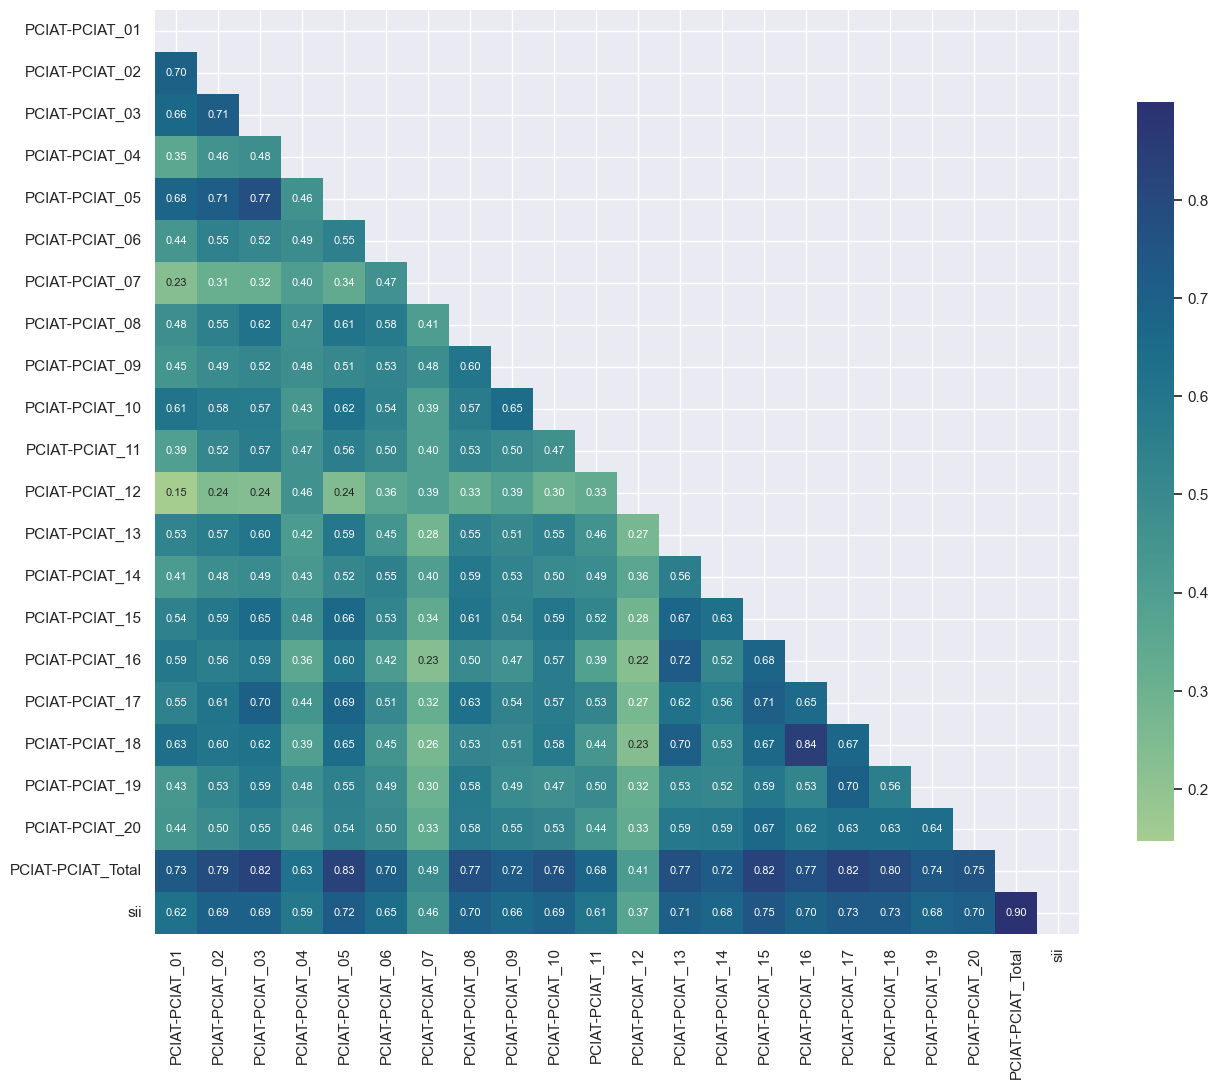

In [ ]:
correlation(PCIAT)

In [ ]:
# determine the mutual information for numerical features
def mutual_info(train):
    y_sampled = train[target]
    mutual_df = train.drop(target,axis=1).select_dtypes(include='number')
    
    # Mutual Info function
    start_time = time.time()
    mutual_info = mutual_info_regression(mutual_df, y_sampled, discrete_features='auto')
    end_time = time.time()
    
    # Create the mutual information table
    mutual_info = pd.Series(mutual_info)
    mutual_info.index = mutual_df.columns
    mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False))
    mutual_info = mutual_info.style.background_gradient("cool")
    
    display(mutual_info)
    elapsed_time = end_time - start_time
    print("Evaluation time:", elapsed_time, "seconds")

PCIAT_nans = PCIAT.dropna()
mutual_info(PCIAT_nans)

Evaluation time: 0.4287135601043701 seconds


<h2>4. Checking Outliers</h2>

<h3> Statistical outliers</h3>
<p>
The outliers I have found using statistical tools, those are the outliers are ruled out of the realm of possibilty by statistical tools  
</p>
<p>
I have choosen to visualize only the columns with the a lot/significant outliers, in order to learn more about those feauture in a cleaner visualization. After that I have used to clip technique that caps outliers in the entire dataframe.
</p>

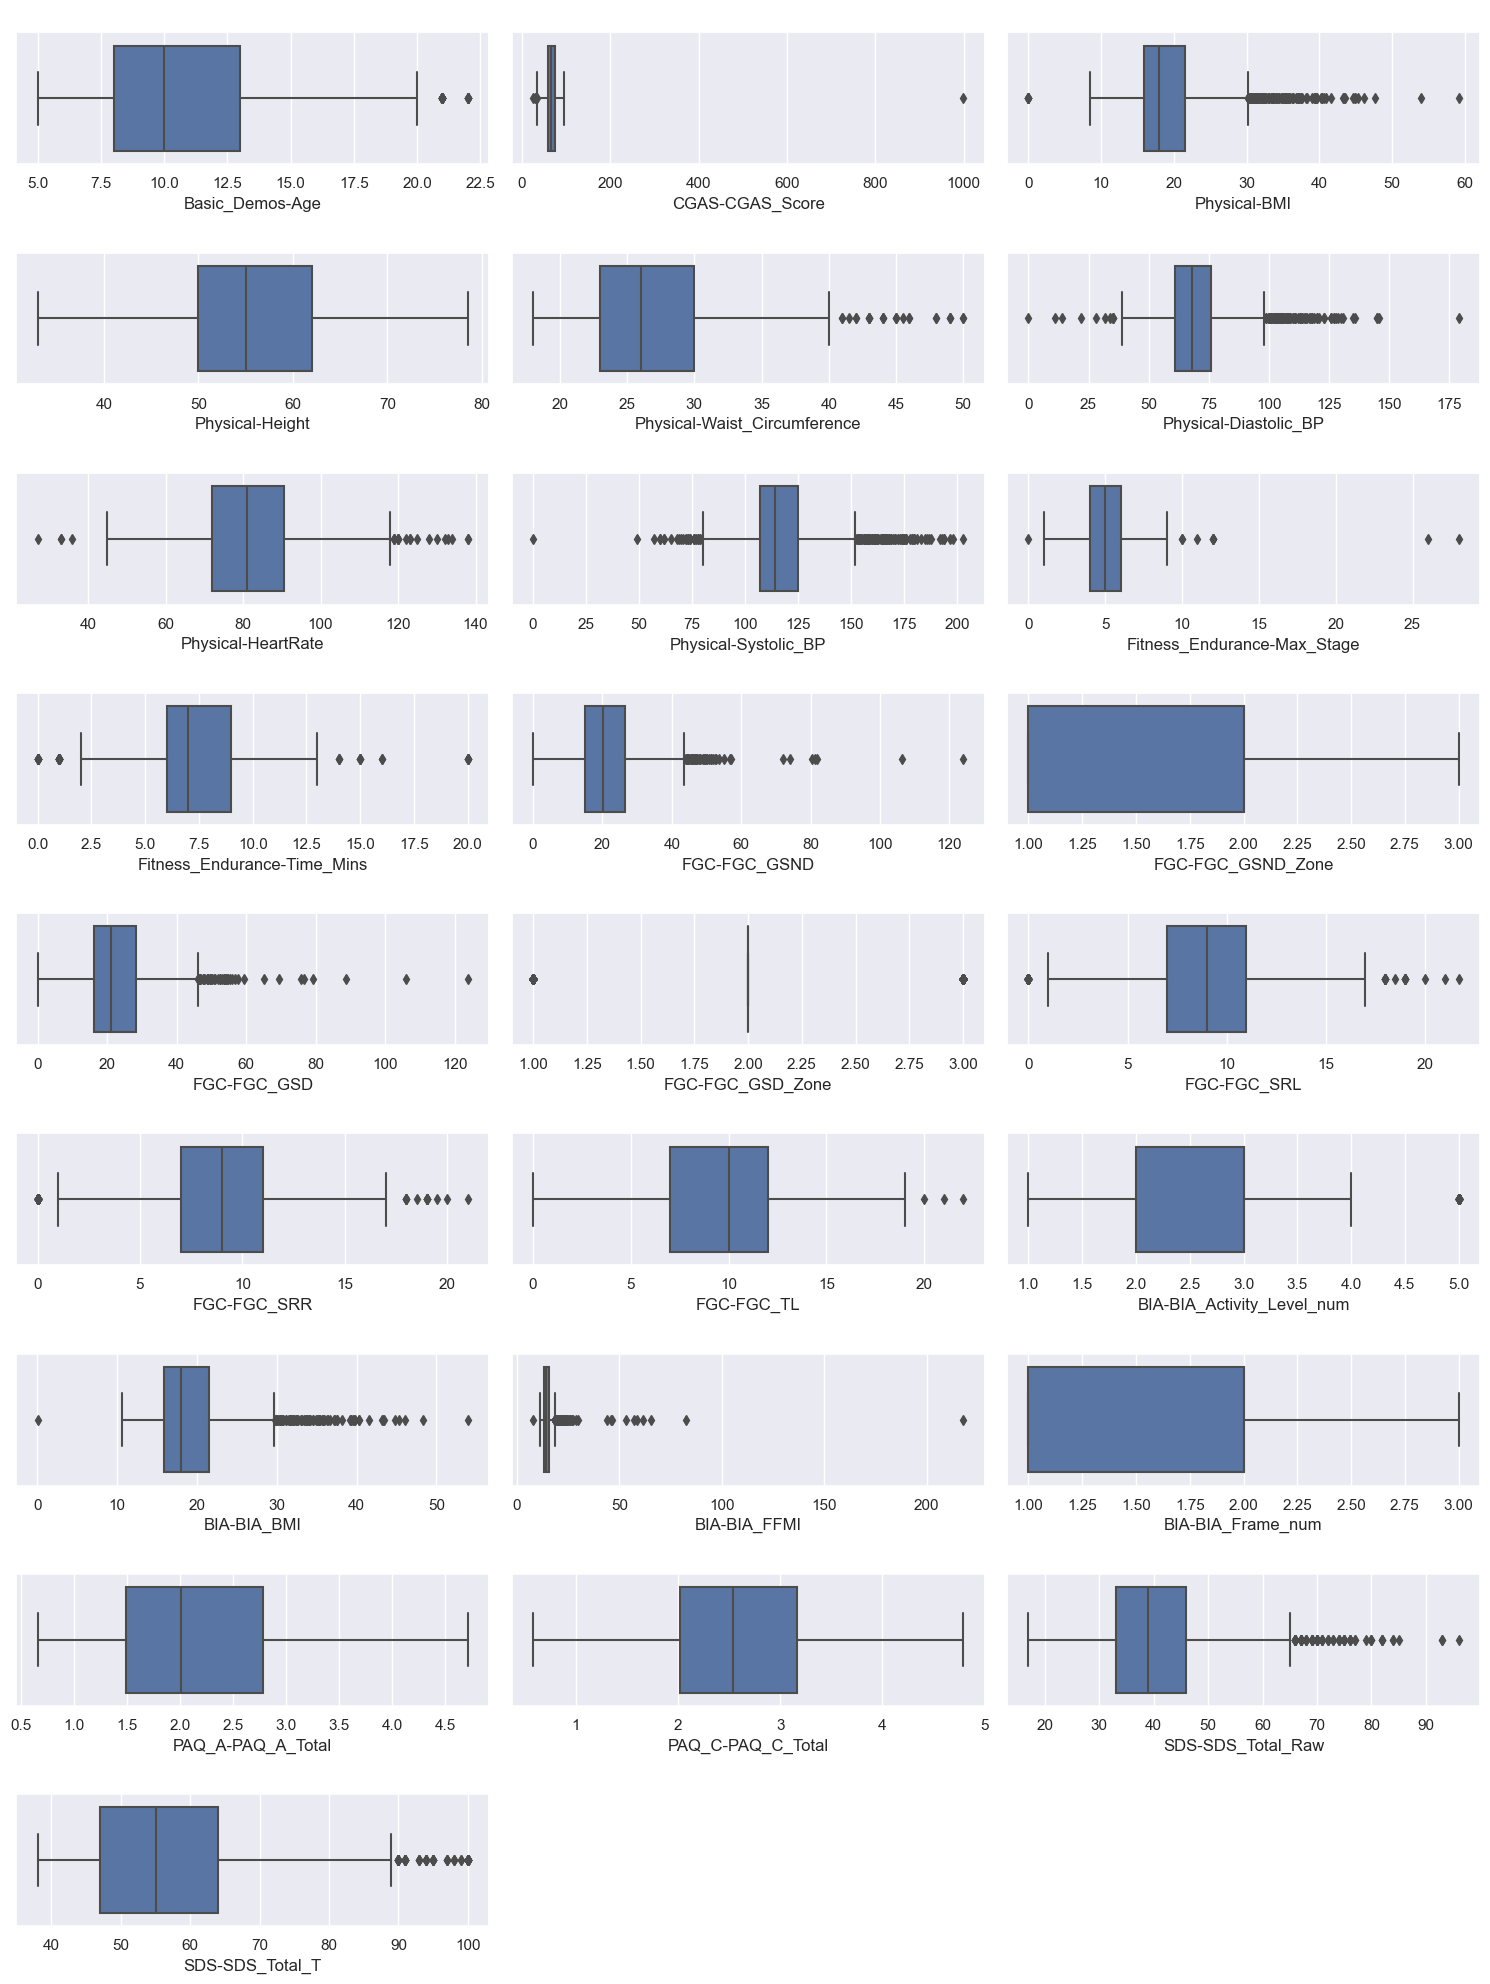

In [ ]:
import math
def boxplots(data,columns_to_plot,n_rows):
    plt.style.use('dark_background')

    sns.set(style="darkgrid")

    fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(15, 20))

    axes = axes.flatten()

    for i, col in enumerate(columns_to_plot):
        sns.boxplot(x=data[col], ax=axes[i])
        axes[i].set_title(f'Box plot of {col}', fontsize=14, color='white')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    
columns_to_plot = pd.DataFrame([train[col] for col in train.select_dtypes(include='number').columns if train[col].mean() / train[col].std() > 2]).T.columns
boxplots(train,columns_to_plot,math.ceil(len(columns_to_plot)/3))

It can be seen that there are some features which have outliers that can hurt there accuracy and is outside of the logical scope of values, for example
<ul>
    <li>CGAS_CGAS-score which have an outlier value of 999 where the mean is 65</li>
    <li>BIA_BIA-FFMI have multiple outliers that hurt the data quality</li>
</ul>

In [ ]:
def cap_outliers(train, columns, method='iqr', threshold=1.5):
    '''
    for the this tests I only want to remove outliers for some of the features and not all.
    For example if I am not cartefull the function will alter the target column 
    because of that it is important to set to change only the desired columns
    '''
    
    train_copy = train.copy()
    
    for col in columns:
        if col != 'sii':
            Q1 = train[col].quantile(0.25)
            Q3 = train[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR

            train_copy[col] = np.clip(train[col], lower_bound, upper_bound)
        
    return train_copy

<h3> Domain knowledge outliers - not necassry </h3>
There are another type of outliers besides the statistical one. Those outliers are in the range of statistical possibilty but are not possible by domain knowledge experience
Those outlier will be when: 
<ul>
    <li>Physical BMI equals 0</li>
    <li>Physical weight equals 0 or lower then 20 pounds</li>
    <li>Diastolic_BP, Systolic_BP will be less then 35 and 65 respectively</li>
    <li>Diastolic_BP is higher then Systolic_BP (as it needs to be the opposite)</li>
    <li>Physical-HeartRate lower then 45 (the world record over a minute stands on 27 BPM). It is safe to assume below 45 HeartRate is extremely rare</li>
</ul>
The objective is to define those outliers through observation of the dataset and remove them 

In [ ]:
# This function is not neccasry
def correct_outliers_dk(df):
    train = df.copy()
    # Define thresholds
    bmi_threshold = 7
    weight_threshold = 35
    diastolic_bp_threshold = 35
    systolic_bp_threshold = 65
    heart_rate_threshold = 45

    # Correct the outliers
    train.loc[train['Physical-BMI'] <= bmi_threshold, 'Physical-BMI'] = bmi_threshold
    train.loc[train['Physical-Weight'] <= weight_threshold, 'Physical-Weight'] = weight_threshold
    train.loc[train['Physical-Diastolic_BP'] < diastolic_bp_threshold, 'Physical-Diastolic_BP'] = diastolic_bp_threshold
    train.loc[train['Physical-Systolic_BP'] < systolic_bp_threshold, 'Physical-Systolic_BP'] = systolic_bp_threshold
    train.loc[train['Physical-HeartRate'] < heart_rate_threshold, 'Physical-HeartRate'] = heart_rate_threshold
    swap_condition = train['Physical-Diastolic_BP'] > train['Physical-Systolic_BP']
    train.loc[swap_condition, ['Physical-Diastolic_BP', 'Physical-Systolic_BP']] = train.loc[swap_condition, ['Physical-Systolic_BP', 'Physical-Diastolic_BP']].values
    
    return train

In [ ]:
def handle_outliers(train): 
    '''
    The following function handle the outliers, both the statistical domain knowledge. 
    The function receives from the user 
    train - the train dataframe set
    '''
    
    train_capper = cap_outliers(train,train.select_dtypes(include='number').columns)
    display(train_capper.describe())
    
    return train_capper

<section id="sec2"> </section>

<h1> EDA </h1>
<ul>
    <li style="margin: 5px 0;"><a href="#Target" style="text-decoration: none; color: #333;">Target Column</a></li>
    <li style="margin: 5px 0;"><a href="#Demographics" style="text-decoration: none; color: #333;">Demographics</a></li>
    <li style="margin: 5px 0;"><a href="#Research Questions" style="text-decoration: none; color: #333;">Research Questions</a></li>
</ul>
  
<a href="#back" style="text-decoration: none; color: #333;">Back to table of contents</a>

<section id="Target"> </section>

<h3>Target Column Visualization</h3>
It can be seen that more than 30% of the data is missing. Besides that the most common category is none which means the condition of most of the participants is ok. 

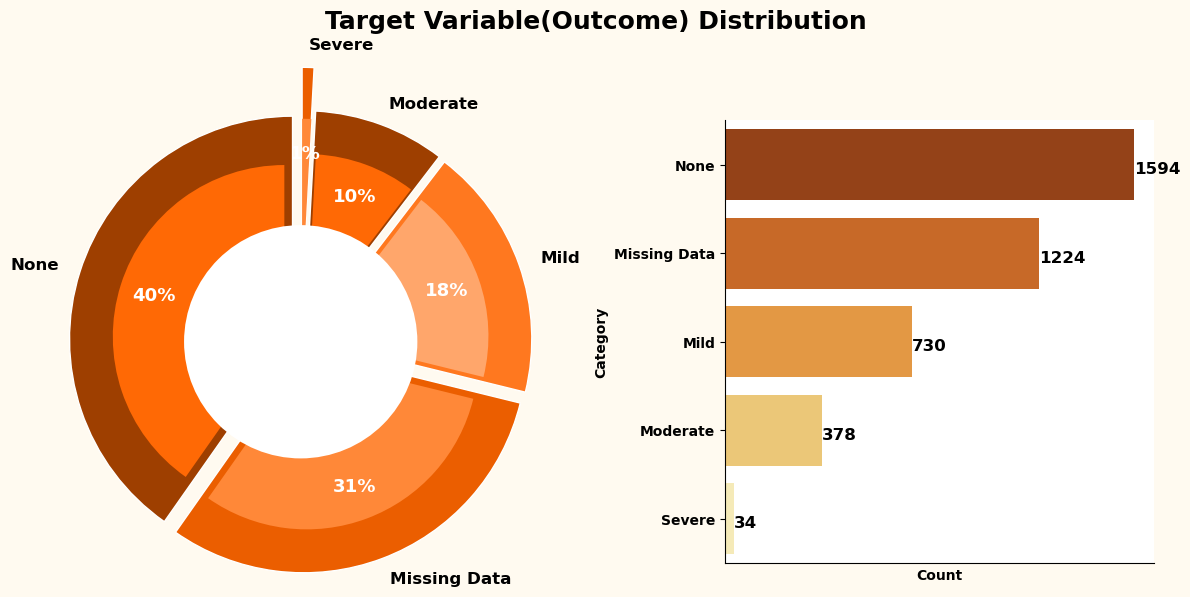

In [ ]:
def plot_count(data, title_name):
    # Set background color
    plt.rcParams['figure.facecolor'] = '#FFFAF0'
    
    f, ax = plt.subplots(1, 2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.2)

    value_counts = data.value_counts()
    num_categories = len(value_counts)

    outer_sizes = value_counts
    inner_sizes = value_counts / num_categories

    outer_colors = ['#9E3F00', '#eb5e00', '#ff781f']
    inner_colors = ['#ff6905', '#ff8838', '#ffa66b']

    ax[0].pie(
        outer_sizes, colors=outer_colors, 
        labels=value_counts.index.tolist(), 
        startangle=90, frame=True, radius=1.3, 
        explode=([0.05]*(num_categories-1) + [.3]),
        wedgeprops={'linewidth' : 1, 'edgecolor' : 'white'}, 
        textprops={'fontsize': 12, 'weight': 'bold'}
    )

    textprops = {
        'size': 13, 
        'weight': 'bold', 
        'color': 'white'
    }

    ax[0].pie(
        inner_sizes, colors=inner_colors,
        radius=1, startangle=90,
        autopct='%1.f%%', explode=([.1]*(num_categories-1) + [.3]),
        pctdistance=0.8, textprops=textprops
    )

    center_circle = plt.Circle((0,0), .68, color='black', fc='white', linewidth=0)
    ax[0].add_artist(center_circle)

    x = value_counts
    y = value_counts.index.tolist()
    sns.barplot(
        x=x, y=y, ax=ax[1],
        palette='YlOrBr_r', orient='horizontal'
    )

    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].tick_params(
        axis='x',         
        which='both',      
        bottom=False,      
        labelbottom=False
    )

    for i, v in enumerate(value_counts):
        ax[1].text(v, i+0.1, str(v), color='black', fontweight='bold', fontsize=12)

    plt.setp(ax[1].get_yticklabels(), fontweight="bold")
    plt.setp(ax[1].get_xticklabels(), fontweight="bold")
    ax[1].set_xlabel('Count', fontweight="bold", color='black')
    ax[1].set_ylabel('Category', fontweight="bold", color='black')

    f.suptitle(f'{title_name}', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
plot_count(mapped_df['sii_label'], 'Target Variable(Outcome) Distribution')

<section id="Demographics"> </section>

<h2>Demographics</h2> 
Investigation on the demographics of the participants 
Almost 2/3 of the participant are girls, and the season of enrollment is fairly equally distributed.
As for the age distribution, both of the plots have a tail to the right and the most common ages are 6-10.

<a href="#sec2" style="text-decoration: none; color: #333;">Back to EDA list</a>

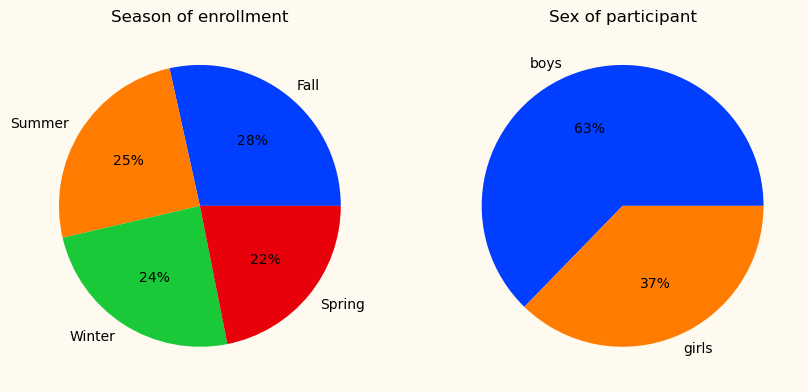

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
palette_color = sns.color_palette('bright') 

vc = train["Basic_Demos-Enroll_Season"].value_counts()
ax1.pie(vc, labels=train["Basic_Demos-Enroll_Season"].unique(),colors=palette_color,autopct='%.0f%%')
ax1.set_title('Season of enrollment')

vc_2= train['Basic_Demos-Sex'].value_counts()
ax2.pie(vc_2, labels=['boys', 'girls'],colors=palette_color,autopct='%.0f%%')
ax2.set_title('Sex of participant')
plt.show()

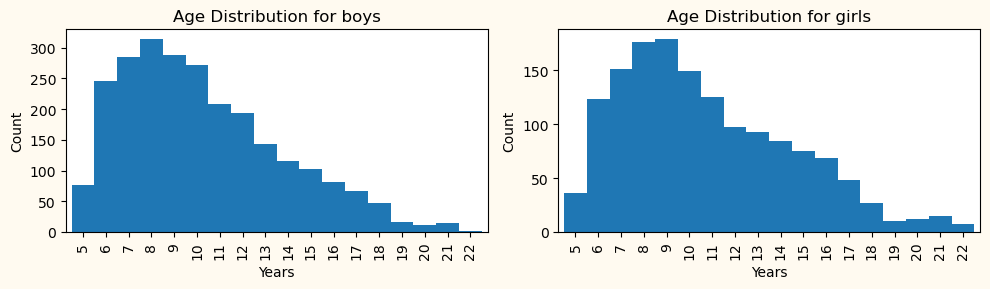

In [ ]:
grouped_by_sex = df_demographics.groupby(['Basic_Demos-Sex'])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

# Plot bar plots for each sex
for i, (sex, group_data) in enumerate(grouped_by_sex):
    if sex ==(0,):
        sex="boys"
    else:
        sex="girls"
        
    ax = axes[i]
    group_data['Basic_Demos-Age'].value_counts().sort_index().plot(kind='bar', ax=ax, width=1)
    ax.set_title(f'Age Distribution for {sex}')
    ax.set_xlabel('Years')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

<section id="Research Questions"> </section>

<h2> Research Questions </h2>

<a href="#sec2" style="text-decoration: none; color: #333;">Back to EDA list</a>

<h4> Are Physical Measures correlated to problematic internet use?</h4>

In [ ]:
PM = concat_df_a_target(df_physical_measures,Target_series)
#df_physical_measures.drop('sii',axis=1,inplace=True)
PM1 = PM.drop('Physical-Waist_Circumference',axis=1)
PM1

Physical-Season  Physical-BMI  Physical-Height  Physical-Weight  \
0               Fall     16.877316             46.0             50.8   
1               Fall     14.035590             48.0             46.0   
2               Fall     16.648696             56.5             75.6   
3             Summer     18.292347             56.0             81.6   
4                NaN           NaN              NaN              NaN   
...              ...           ...              ...              ...   
3955            Fall     16.362460             59.5             82.4   
3956          Spring     18.764678             53.5             76.4   
3957          Winter     21.441500             60.0            109.8   
3958          Winter     12.235895             70.7             87.0   
3959          Winter           NaN              NaN              NaN   

      Physical-Diastolic_BP  Physical-HeartRate  Physical-Systolic_BP  sii  
0                       NaN                 NaN                   NaN  2.0  
1                      75.0                70.0                 122.0  0.0  
2                      65.0                94.0                 117.0  0.0  
3                      60.0                97.0                 117.0  1.0  
4                       NaN                 NaN                   NaN  NaN  
...                     ...                 ...                   ...  ...  
3955                   71.0                70.0                 104.0  1.0  
3956                   60.0                78.0                 118.0  NaN  
3957                   79.0                99.0                 116.0  1.0  
3958                   59.0                61.0                 113.0  0.0  
3959                    NaN                 NaN                   NaN  NaN  

[3960 rows x 8 columns]

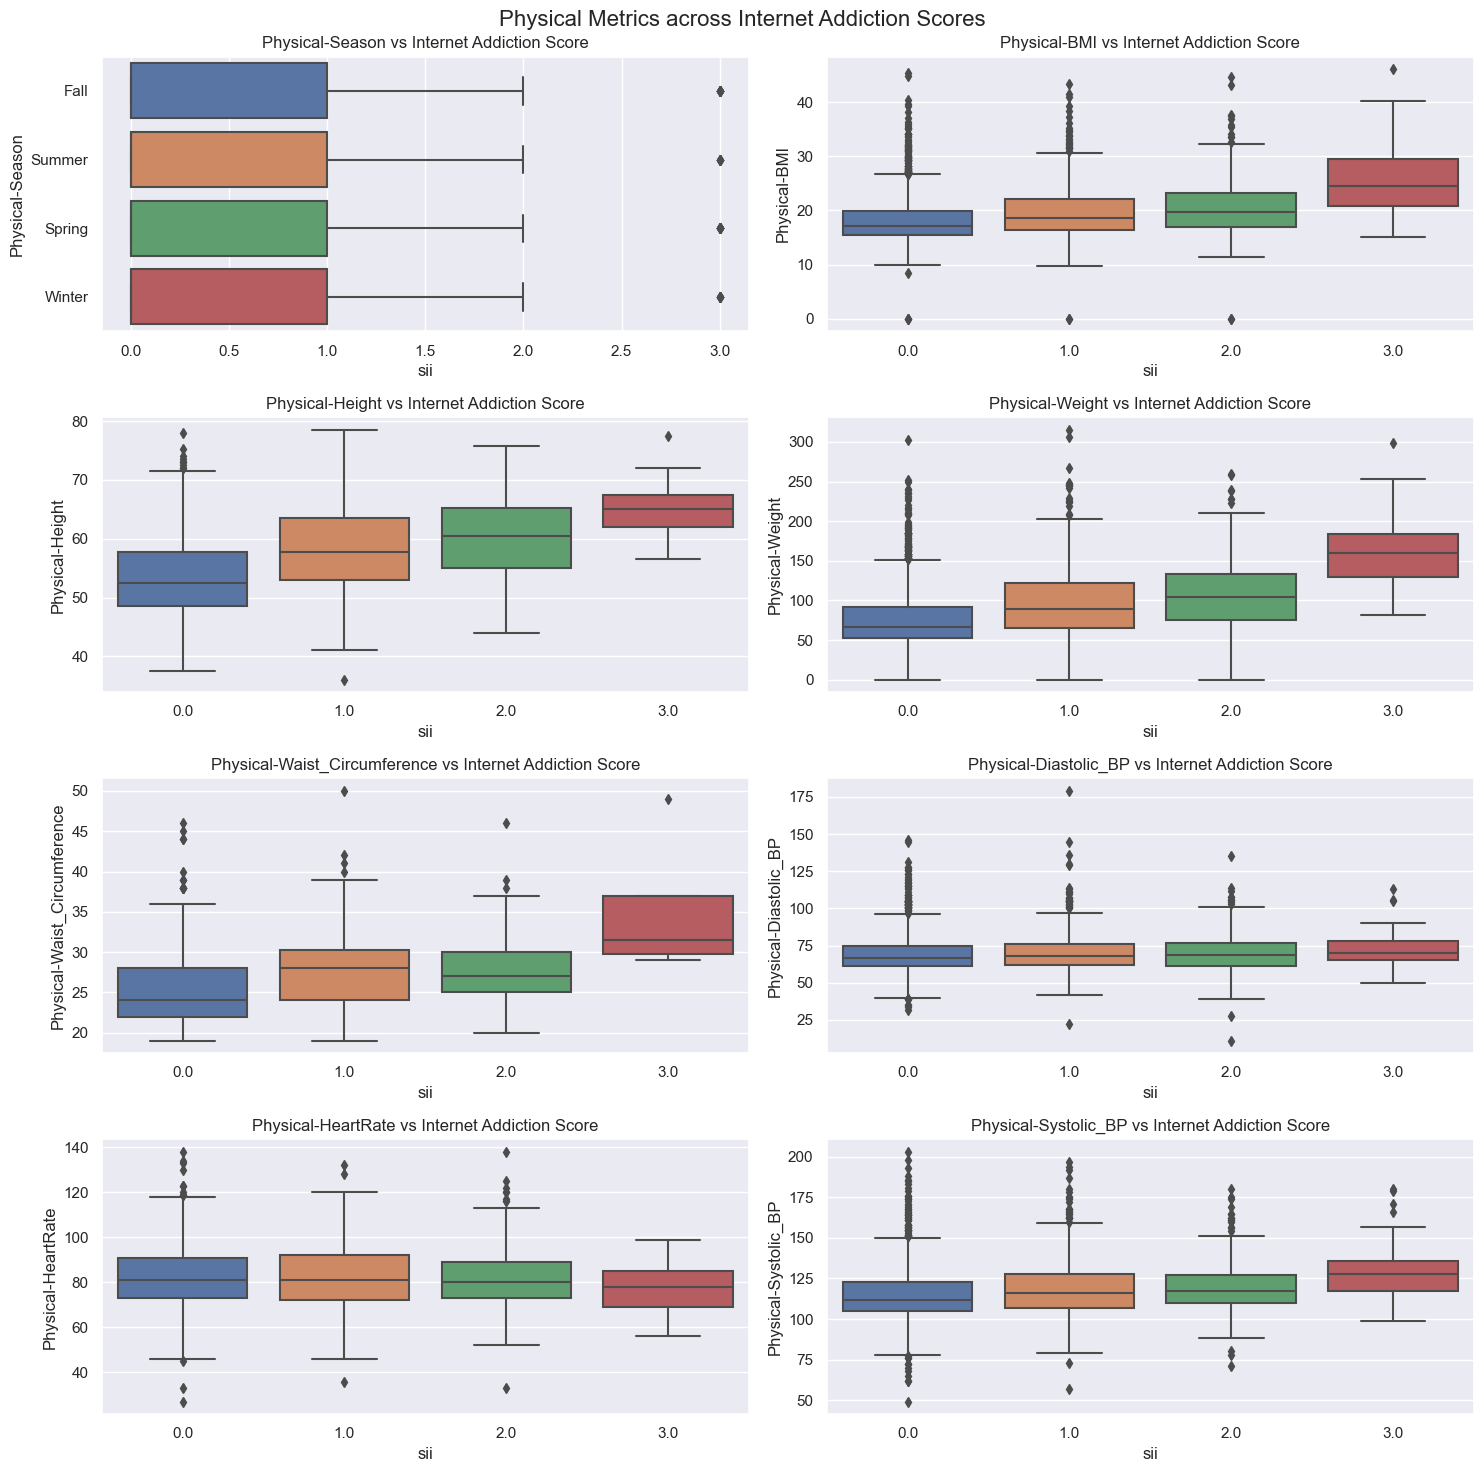

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 2, figsize=(15, 15))
fig.suptitle('Physical Metrics across Internet Addiction Scores', fontsize=16)

for i, metric in enumerate(PM.drop('sii',axis=1).columns):
    row = i // 2
    col = i % 2
    sns.boxplot(x='sii', y=metric, data=PM, ax=axes[row, col])
    axes[row, col].set_title(f'{metric} vs Internet Addiction Score')

plt.tight_layout()
plt.show()

<h3>Insights</h3> 
<p>It can be seen that the features that have a the biggest connection to the sii score are BMI, Weight, Height, Waist circumstances and Systolic blood prussure. In all of them it can be seem that for the higher scores they values tend to be higher</p>   

<h4> Does gender affects SII score?</h4>
it can be seen that the distributions are similar in both genders, therefore it can be detected that the answer is negative

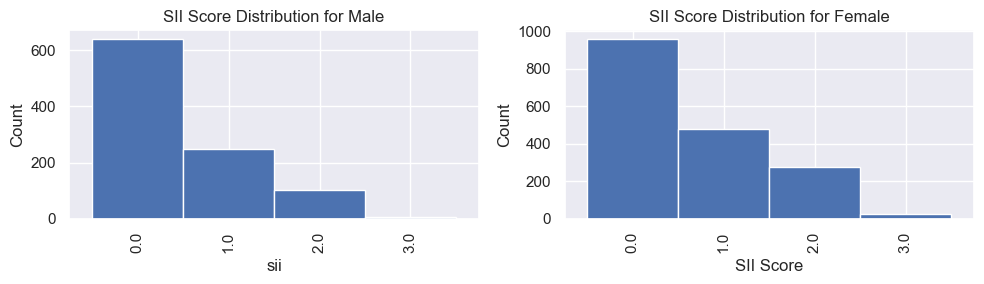

In [ ]:
Demo = concat_df_a_target(df_demographics,Target_series)
Demo_grouped = Demo.groupby(['Basic_Demos-Sex', 'sii']).size().unstack()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

# Plot for Male
Demo_grouped.loc[0].plot(kind='bar', ax=axes[0], title='SII Score Distribution for Male',width=1)
axes[0].set_xlabel('SII Score')
axes[0].set_ylabel('Count')

# Plot for Female
Demo_grouped.loc[1].plot(kind='bar', ax=axes[1], title='SII Score Distribution for Female',width=1)
axes[1].set_xlabel('SII Score')
axes[1].set_ylabel('Count')


plt.tight_layout()
plt.show()

<h4> Does mental health affects SII score?</h4>
The CGAS metric - 
The Children’s Global Assessment Scale (CGAS), adapted from the Global Assessment Scale for adults, is a rating of general functioning for children and young people aged 4-16 years old. The clinician assesses a range of aspects of psychological and social functioning and gives the child or young person a single score between 1 and 100, based on their lowest level of functioning. The score puts them in one of ten categories that range from “needs constant supervision” (1-10) to “superior functioning” (91-100). The measure can be used by clinicians as well as researchers to complement other scales measuring more specific symptoms.

The vast majority of the Scores are between 51-80. There is a tendency for lower mental health scores to have problems, as it can be seen that for every group the percentages of healthy participants is getting a dropping by a bit and when you compare the the lowest significant group (31-40) to the highest (81-90) there is an 22% difference 

In [ ]:
def create_grouped_table(train):
    # Calculate the percentage for each score within each category score bin
    total_counts = train.sum(axis=1)
    train_percentage = train.div(total_counts, axis=0) * 100

    # Add the Sample column that specify how many exampled were found in each range
    train_percentage['Sample'] = train.sum(axis=1)

    # Calculate the overall percentage for each score
    total_counts = train.sum(axis=0)
    overall_percentages = (total_counts / total_counts.sum()) * 100

    # Add a new row to the DataFrame
    train_percentage.loc['Total'] = overall_percentages

    display(train_percentage)

In [ ]:
# Group the CGAS scores in order to search for relationships
CGAS = concat_df_a_target(df_childrens_global_assessment_scale,Target_series)
CGAS['CGAS_Score_Bin'] = pd.cut(CGAS['CGAS-CGAS_Score'], bins=range(1, 102, 10), right=False)
CGAS_grouped = CGAS.groupby(['CGAS_Score_Bin', 'sii']).size().unstack()

create_grouped_table(CGAS_grouped)

sii                   0.0        1.0        2.0       3.0  Sample
CGAS_Score_Bin                                                   
[1, 11)               NaN        NaN        NaN       NaN     0.0
[11, 21)              NaN        NaN        NaN       NaN     0.0
[21, 31)        50.000000  50.000000   0.000000  0.000000     2.0
[31, 41)        47.619048  26.190476  19.047619  7.142857    42.0
[41, 51)        53.937008  27.559055  16.141732  2.362205   254.0
[51, 61)        56.183746  29.505300  13.604240  0.706714   566.0
[61, 71)        57.662338  25.974026  14.545455  1.818182   770.0
[71, 81)        59.433962  25.849057  14.339623  0.377358   530.0
[81, 91)        69.135802  25.925926   4.938272  0.000000   162.0
[91, 101)       75.000000  25.000000   0.000000  0.000000    16.0
Total           58.027327  26.985482  13.748933  1.238258     NaN

<h4> Does Sleep Disturbance affects SII score?</h4>

The vast majority of the Scores are between 31-50.
There is a correlation between lower sleep disturbance score (which means less problems) to lower percentage of internet problematic use. As it can be seen that for every group the percentages of healthy participants is getting a lower and when comparing lowest significant group (21-30) to the highest (61-70) there is an 40% difference 

In [ ]:
SDS = concat_df_a_target(df_sleep_disturbance_scale,Target_series)
SDS['SDS_Bin'] = pd.cut(SDS['SDS-SDS_Total_Raw'], bins=range(1, 102, 10), right=False)
SDS_grouped = SDS.groupby(['SDS_Bin', 'sii']).size().unstack()

create_grouped_table(SDS_grouped)

sii               0.0        1.0         2.0       3.0  Sample
SDS_Bin                                                       
[1, 11)           NaN        NaN         NaN       NaN     0.0
[11, 21)     0.000000   0.000000  100.000000  0.000000     1.0
[21, 31)    73.667712  19.435737    6.896552  0.000000   319.0
[31, 41)    63.452709  25.895317   10.101010  0.550964  1089.0
[41, 51)    52.661871  28.920863   16.690647  1.726619   695.0
[51, 61)    44.178082  33.219178   20.547945  2.054795   292.0
[61, 71)    34.343434  30.303030   30.303030  5.050505    99.0
[71, 81)    52.000000  20.000000   24.000000  4.000000    25.0
[81, 91)    33.333333  50.000000   16.666667  0.000000     6.0
[91, 101)  100.000000   0.000000    0.000000  0.000000     1.0
Total       58.211318  26.909379   13.692125  1.187178     NaN

In [ ]:
data_dict['Instrument'].value_counts()

Instrument
Parent-Child Internet Addiction Test             22
Bio-electric Impedance Analysis                  17
FitnessGram Child                                15
Physical Measures                                 8
FitnessGram Vitals and Treadmill                  4
Demographics                                      3
Sleep Disturbance Scale                           3
Children's Global Assessment Scale                2
Physical Activity Questionnaire (Adolescents)     2
Physical Activity Questionnaire (Children)        2
Internet Use                                      2
Name: count, dtype: int64

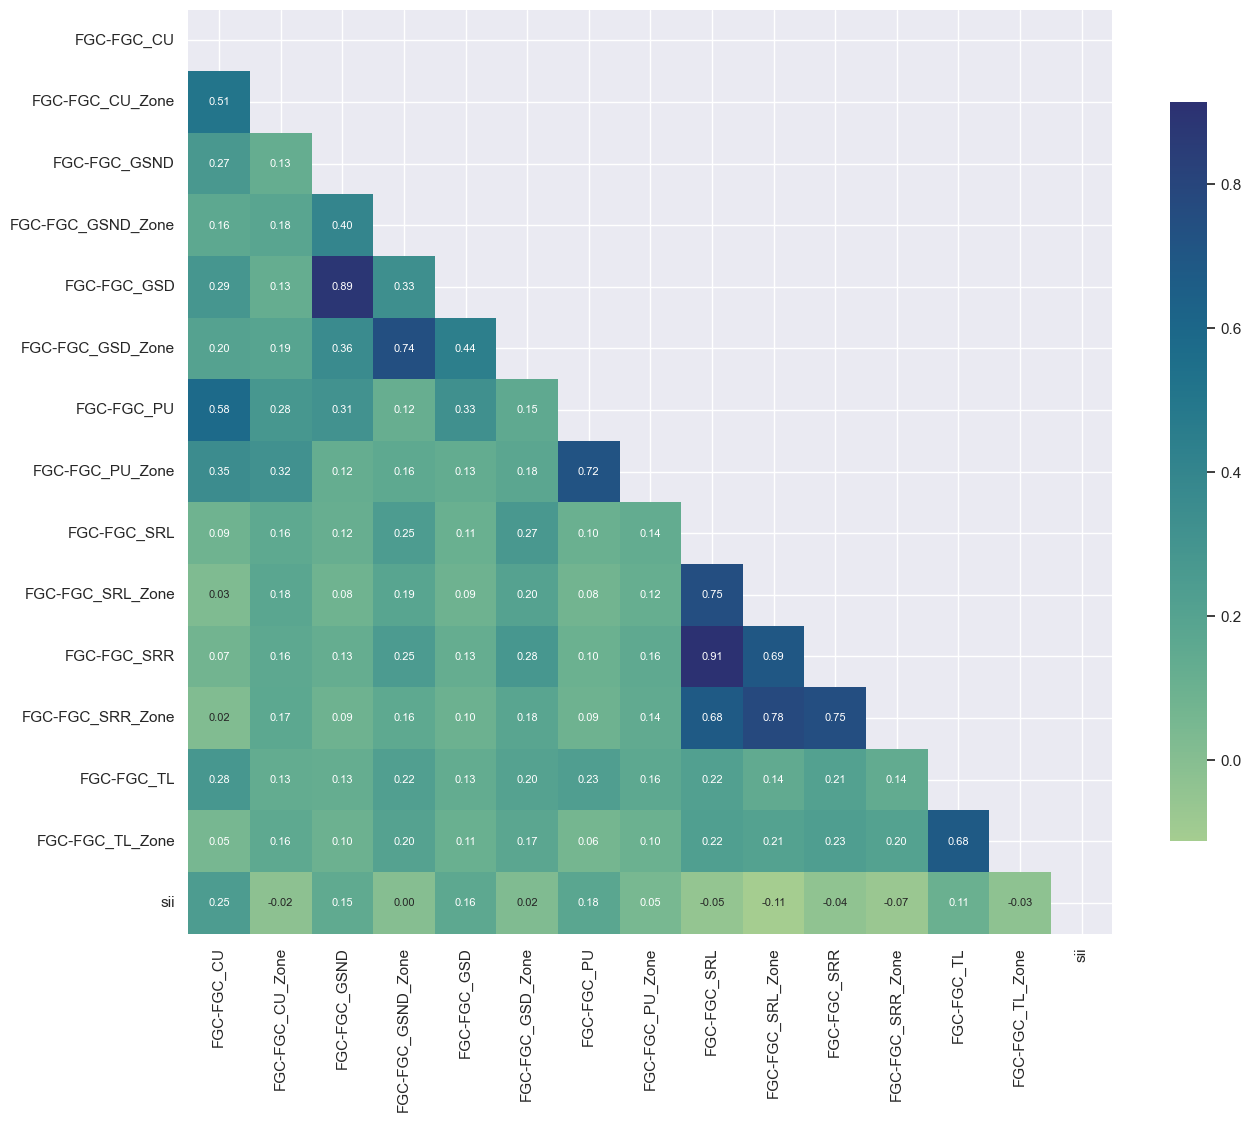

In [ ]:
#FGC - FitnessGram Child
FGC = concat_df_a_target(df_fitnessgram_child,Target_series)
correlation(FGC)

Basic_Demos-Age  Basic_Demos-Sex  CGAS-CGAS_Score  Physical-BMI  \
count      3960.000000      3960.000000      2421.000000   3022.000000   
mean         10.426894         0.372727        65.093350     19.144650   
std           3.554845         0.483591        11.775849      4.379203   
min           5.000000         0.000000        35.000000      7.316511   
25%           8.000000         0.000000        59.000000     15.869350   
50%          10.000000         0.000000        65.000000     17.937682   
75%          13.000000         1.000000        75.000000     21.571244   
max          20.500000         1.000000        99.000000     30.124083   

       Physical-Height  Physical-Weight  Physical-Waist_Circumference  \
count      3027.000000      3076.000000                    898.000000   
mean         55.946713        88.836099                     27.151002   
std           7.473764        40.475990                      5.176501   
min          33.000000        35.000000                     18.000000   
25%          50.000000        57.200000                     23.000000   
50%          55.000000        77.000000                     26.000000   
75%          62.000000       113.800000                     30.000000   
max          78.500000       198.700000                     40.500000   

       Physical-Diastolic_BP  Physical-HeartRate  Physical-Systolic_BP  ...  \
count            2954.000000         2967.000000           2954.000000  ...   
mean               69.209377           81.569093            116.546716  ...   
std                11.897651           13.465438             15.049979  ...   
min                38.500000           45.000000             80.000000  ...   
25%                61.000000           72.000000            107.000000  ...   
50%                68.000000           81.000000            114.000000  ...   
75%                76.000000           90.500000            125.000000  ...   
max                98.500000          118.250000            152.000000  ...   

       PCIAT-PCIAT_16  PCIAT-PCIAT_17  PCIAT-PCIAT_18  PCIAT-PCIAT_19  \
count     2728.000000     2725.000000     2728.000000     2730.000000   
mean         1.452346        1.627890        1.613636        1.158974   
std          1.495600        1.445622        1.529178        1.343661   
min          0.000000        0.000000        0.000000        0.000000   
25%          0.000000        0.000000        0.000000        0.000000   
50%          1.000000        1.000000        1.000000        1.000000   
75%          2.000000        3.000000        2.000000        2.000000   
max          5.000000        5.000000        5.000000        5.000000   

       PCIAT-PCIAT_20  PCIAT-PCIAT_Total  SDS-SDS_Total_Raw  SDS-SDS_Total_T  \
count     2733.000000        2736.000000        2609.000000      2606.000000   
mean         0.815404          27.863304          40.875623        57.577322   
std          0.876449          20.242424           9.766982        12.674429   
min          0.000000           0.000000          17.000000        38.000000   
25%          0.000000          12.000000          33.000000        47.000000   
50%          1.000000          26.000000          39.000000        55.000000   
75%          1.000000          41.000000          46.000000        64.000000   
max          2.500000          84.500000          65.500000        89.500000   

       PreInt_EduHx-computerinternet_hoursday          sii  
count                             3301.000000  2736.000000  
mean                                 1.060588     0.580409  
std                                  1.094875     0.771122  
min                                  0.000000     0.000000  
25%                                  0.000000     0.000000  
50%                                  1.000000     0.000000  
75%                                  2.000000     1.000000  
max                                  3.000000     3.000000  

[8 rows x 70 columns]

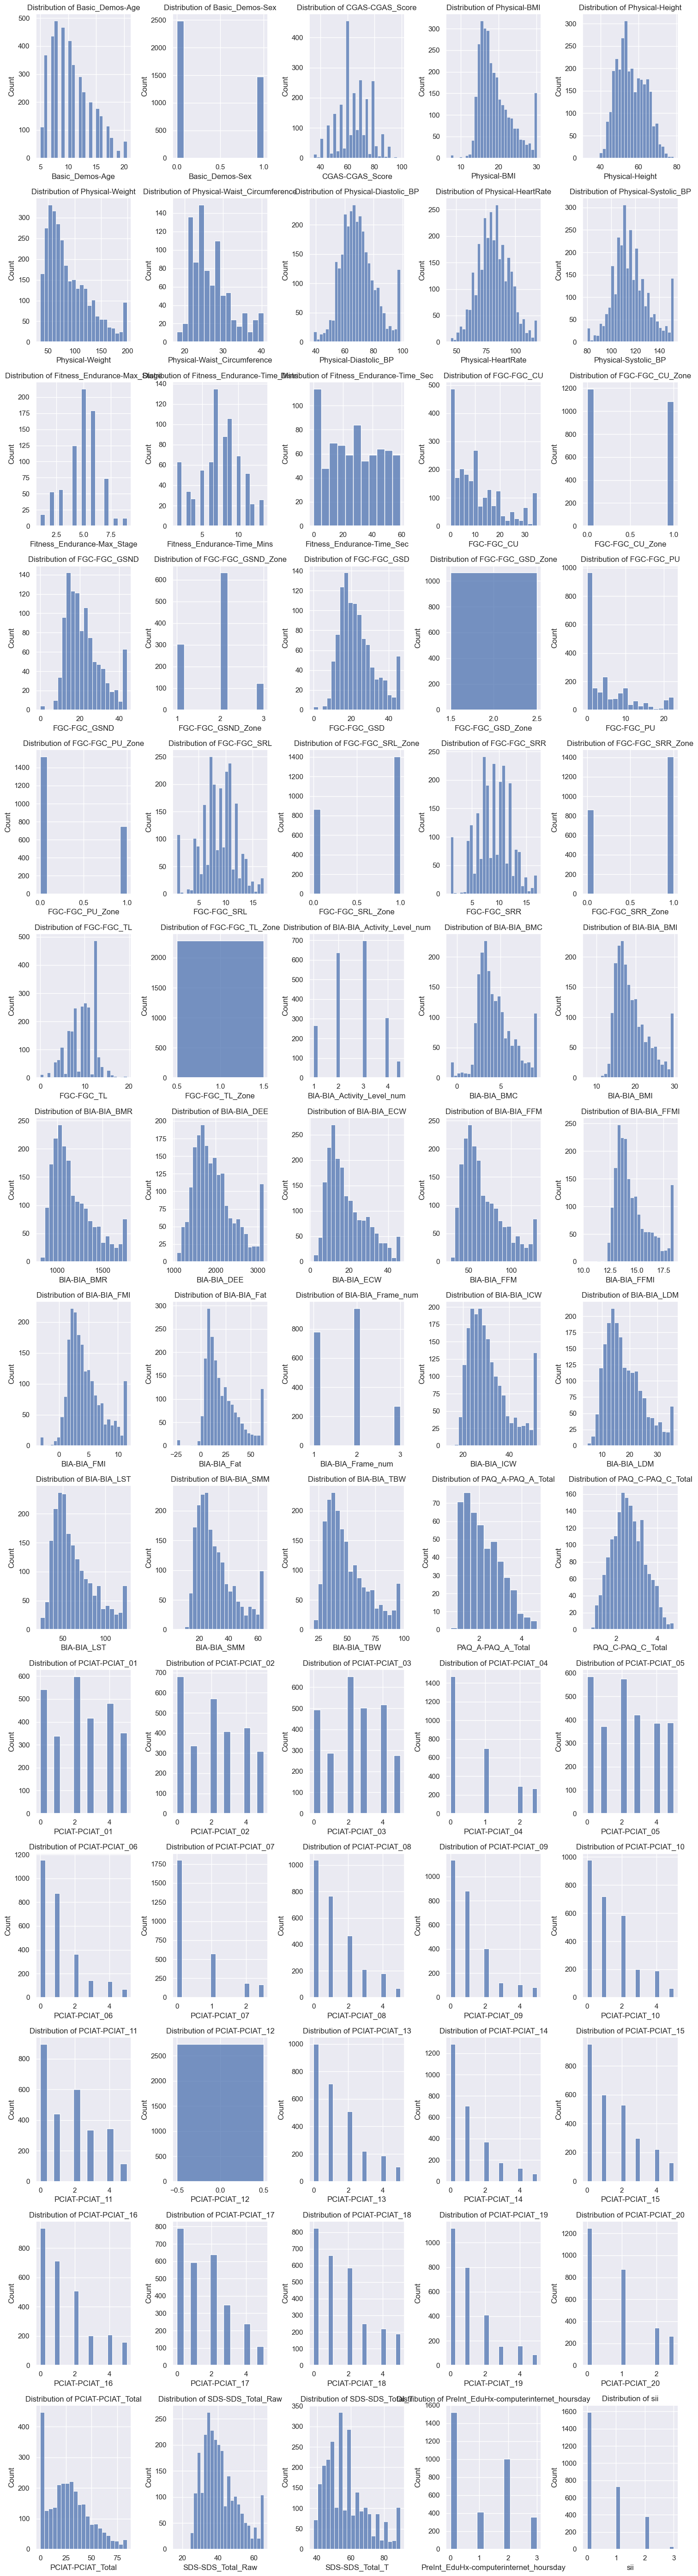

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")
def plot_distplots(train, num_cols_per_row = 5):

    # Get numerical columns
    numeric_cols = train.select_dtypes(include=['number']).columns
    
    num_rows = int(np.ceil(len(numeric_cols) / num_cols_per_row))
    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(15, 4 * num_rows))
    
    axes = axes.flatten()
    # Plot distribution plots for each numerical column
    for i, col in enumerate(numeric_cols):
        sns.histplot(train[col], ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
    # Adjust layout to remove extra subplots
    for i in range(len(numeric_cols), len(axes)):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

plot_distplots(handle_outliers(train.select_dtypes(include=['number'])))

<h3> Insights </h3>
It seems that most of the physical features are distributed in a Gaussian distribution.
Those include both features like weight and height and BIA features

<h1> Feature Engineering</h1>

<h3> Create Features </h3> 
Domain knowledge and insights from EDA used to create new features that will 

In [ ]:
def create_features(train):
    '''
    I create new features in this function based on domain knowledge 
    '''
    BIA[""]
    

<h3> Highly correlated pairs</h3>
Searching for highly correlated independent features.
If there are any remove to avoid overfitting, redundancy of features, multicollinearty and to improve the cleaness of the data.

In [ ]:
def high_correlation_pairs(train, threshold=0.95):
    # Calculate the correlation matrix
    corr_matrix = train.select_dtypes(include='number').corr("pearson")
    
    # Select pairs of features with correlations above the threshold
    high_corr_pairs = (
        corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # Upper triangle without diagonal
        .stack()  # Convert to Series
        .reset_index()
    )
    
    # Rename columns for readability
    high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
    
    # Filter by the correlation threshold (both positive and negative)
    high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'].abs() > threshold]
    
    # Display the high correlation pairs
    print("Highly correlated feature pairs (|correlation| > {}):".format(threshold))
    print(high_corr_pairs.to_string(index=False))
    
    return high_corr_pairs

<h3>Low Corrlated Features</h3>
Find features that have low correlation to the target series, later those features will be removed from the training set to reduce noise and improve overall score.
The filtering will be based on a threshold

In [ ]:
# Find features with less then threshold correlation
def low_correlated_features(train, target_column, threshold=0.1):

    corr_matrix = train.corr()
    target_correlations = corr_matrix[target_column].abs()
    low_correlated_features = target_correlations[target_correlations < threshold].index
    
    return low_correlated_features

In [ ]:
def feature_engineering(df,tst,Target_series=Target_series):
    '''
        This function is used to clean the data and make sure it is ready for modeling
        input:
            df: the train dataframe
            tst: the test dataframe
            
    '''
    train = df.copy()
    test= tst.copy()
    
    ### Drop unique columns for train dataframe (later add the target series as it was dropped)
    cols_diff = feature_difference(train, test) 
    train = train.drop(list(cols_diff),axis=1)
    train = concat_df_a_target(train, Target_series)
    
    display(train)
    ### Feature creation 
    #feature_creation(train,test)
    
    ### Handle missing values

    
    ### Drop high correlation pairs
    high_corr_pairs = high_correlation_pairs(train)
    # take the second feature from each pair and drop them from the dataframe
    features_to_remove = high_corr_pairs['Feature 2'].tolist()
    train = train.drop(features_to_remove, axis=1)
    test = test.drop(features_to_remove, axis=1)
    
    # Drop features with low correlation to target
    low_corr_cols = low_correlated_features(train.select_dtypes(include='number'),'sii')
    train = train.drop(low_corr_cols,axis=1)
    test = test.drop(low_corr_cols,axis=1)
    
    ### Deal with outliers
    train = handle_outliers(train)

    ### Drop categorical columns - note that we add only the relevant one later 
    cat_cols = train.select_dtypes(exclude='number').columns
    train = train.drop(cat_cols,axis=1)
    test = test.drop(cat_cols,axis=1)
    
    return train, test 

In [ ]:
train_processed,test_processed = feature_engineering(train,test)

Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex CGAS-Season  \
0                         Fall                5                0      Winter   
1                       Summer                9                0         NaN   
2                       Summer               10                1        Fall   
3                       Winter                9                0        Fall   
4                       Spring               18                1      Summer   
...                        ...              ...              ...         ...   
3955                      Fall               13                0      Spring   
3956                    Winter               10                0         NaN   
3957                      Fall               11                0      Spring   
3958                    Spring               13                0      Spring   
3959                    Spring               11                0         NaN   

      CGAS-CGAS_Score Physical-Season  Physical-BMI  Physical-Height  \
0                51.0            Fall     16.877316             46.0   
1                 NaN            Fall     14.035590             48.0   
2                71.0            Fall     16.648696             56.5   
3                71.0          Summer     18.292347             56.0   
4                 NaN             NaN           NaN              NaN   
...               ...             ...           ...              ...   
3955             60.0            Fall     16.362460             59.5   
3956              NaN          Spring     18.764678             53.5   
3957             68.0          Winter     21.441500             60.0   
3958             70.0          Winter     12.235895             70.7   
3959              NaN          Winter           NaN              NaN   

      Physical-Weight  Physical-Waist_Circumference  ...  PAQ_A-Season  \
0                50.8                           NaN  ...           NaN   
1                46.0                          22.0  ...           NaN   
2                75.6                           NaN  ...           NaN   
3                81.6                           NaN  ...           NaN   
4                 NaN                           NaN  ...        Summer   
...               ...                           ...  ...           ...   
3955             82.4                           NaN  ...           NaN   
3956             76.4                          27.0  ...           NaN   
3957            109.8                           NaN  ...           NaN   
3958             87.0                           NaN  ...           NaN   
3959              NaN                           NaN  ...           NaN   

      PAQ_A-PAQ_A_Total  PAQ_C-Season PAQ_C-PAQ_C_Total  SDS-Season  \
0                   NaN           NaN               NaN         NaN   
1                   NaN          Fall             2.340        Fall   
2                   NaN        Summer             2.170        Fall   
3                   NaN        Winter             2.451      Summer   
4                  1.04           NaN               NaN         NaN   
...                 ...           ...               ...         ...   
3955                NaN        Winter             3.260      Winter   
3956                NaN        Winter             2.340         NaN   
3957                NaN        Winter             2.729      Winter   
3958                NaN        Spring             3.300      Spring   
3959                NaN           NaN               NaN         NaN   

      SDS-SDS_Total_Raw  SDS-SDS_Total_T PreInt_EduHx-Season  \
0                   NaN              NaN                Fall   
1                  46.0             64.0              Summer   
2                  38.0             54.0              Summer   
3                  31.0             45.0              Winter   
4                   NaN              NaN                 NaN   
...                 ...              ...             

Highly correlated feature pairs (|correlation| > 0.95):
        Feature 1       Feature 2  Correlation
     Physical-BMI     BIA-BIA_BMI     0.968849
      BIA-BIA_BMC     BIA-BIA_BMR     0.989151
      BIA-BIA_BMC     BIA-BIA_DEE     0.978063
      BIA-BIA_BMC     BIA-BIA_ECW     0.988967
      BIA-BIA_BMC     BIA-BIA_FFM     0.989151
      BIA-BIA_BMC     BIA-BIA_Fat    -0.991534
      BIA-BIA_BMC     BIA-BIA_ICW     0.978078
      BIA-BIA_BMC     BIA-BIA_LDM     0.993702
      BIA-BIA_BMC     BIA-BIA_LST     0.962998
      BIA-BIA_BMC     BIA-BIA_SMM     0.970374
      BIA-BIA_BMC     BIA-BIA_TBW     0.985577
      BIA-BIA_BMR     BIA-BIA_DEE     0.993108
      BIA-BIA_BMR     BIA-BIA_ECW     0.999119
      BIA-BIA_BMR     BIA-BIA_FFM     1.000000
      BIA-BIA_BMR     BIA-BIA_Fat    -0.976677
      BIA-BIA_BMR     BIA-BIA_ICW     0.997115
      BIA-BIA_BMR     BIA-BIA_LDM     0.998667
      BIA-BIA_BMR     BIA-BIA_LST     0.992142
      BIA-BIA_BMR     BIA-BIA_SMM     0.992282
    

Basic_Demos-Age  Basic_Demos-Sex  Physical-BMI  Physical-Height  \
count      3960.000000      3960.000000   3022.000000      3027.000000   
mean         10.426894         0.372727     19.144650        55.946713   
std           3.554845         0.483591      4.379203         7.473764   
min           5.000000         0.000000      7.316511        33.000000   
25%           8.000000         0.000000     15.869350        50.000000   
50%          10.000000         0.000000     17.937682        55.000000   
75%          13.000000         1.000000     21.571244        62.000000   
max          20.500000         1.000000     30.124083        78.500000   

       Physical-Weight  Physical-Waist_Circumference  Physical-Systolic_BP  \
count      3076.000000                    898.000000           2954.000000   
mean         88.136749                     27.151002            116.535206   
std          41.682765                      5.176501             15.052733   
min           0.000000                     18.000000             80.000000   
25%          57.200000                     23.000000            107.000000   
50%          77.000000                     26.000000            114.000000   
75%         113.800000                     30.000000            125.000000   
max         198.700000                     40.500000            152.000000   

        FGC-FGC_CU  FGC-FGC_GSND  FGC-FGC_GSD   FGC-FGC_PU  FGC-FGC_SRL_Zone  \
count  2322.000000   1074.000000  1074.000000  2310.000000       2267.000000   
mean     10.699182     21.964851    23.062407     5.294156          0.618880   
std       9.822283      9.018706     9.381096     6.390375          0.485769   
min       0.000000      0.000000     0.000000     0.000000          0.000000   
25%       3.000000     15.100000    16.200000     0.000000          0.000000   
50%       9.000000     20.050000    21.200000     3.000000          1.000000   
75%      15.750000     26.600000    28.175000     9.000000          1.000000   
max      34.875000     43.850000    46.137500    22.500000          1.000000   

        FGC-FGC_TL  BIA-BIA_FFMI  BIA-BIA_Frame_num  SDS-SDS_Total_Raw  \
count  2324.000000   1991.000000        1991.000000        2609.000000   
mean      9.250839     14.629232           1.745354          40.875623   
std       2.981581      1.640669           0.680635           9.766982   
min       0.000000     10.373575           1.000000          17.000000   
25%       7.000000     13.408000           1.000000          33.000000   
50%      10.000000     14.092500           2.000000          39.000000   
75%      12.000000     15.430950           2.000000          46.000000   
max      19.500000     18.465375           3.000000          65.500000   

       PreInt_EduHx-computerinternet_hoursday          sii  
count                             3301.000000  2736.000000  
mean                                 1.060588     0.580409  
std                                  1.094875     0.771122  
min                                  0.000000     0.000000  
25%                                  0.000000     0.000000  
50%                                  1.000000     0.000000  
75%                                  2.000000     1.000000  
max                                  3.000000     3.000000

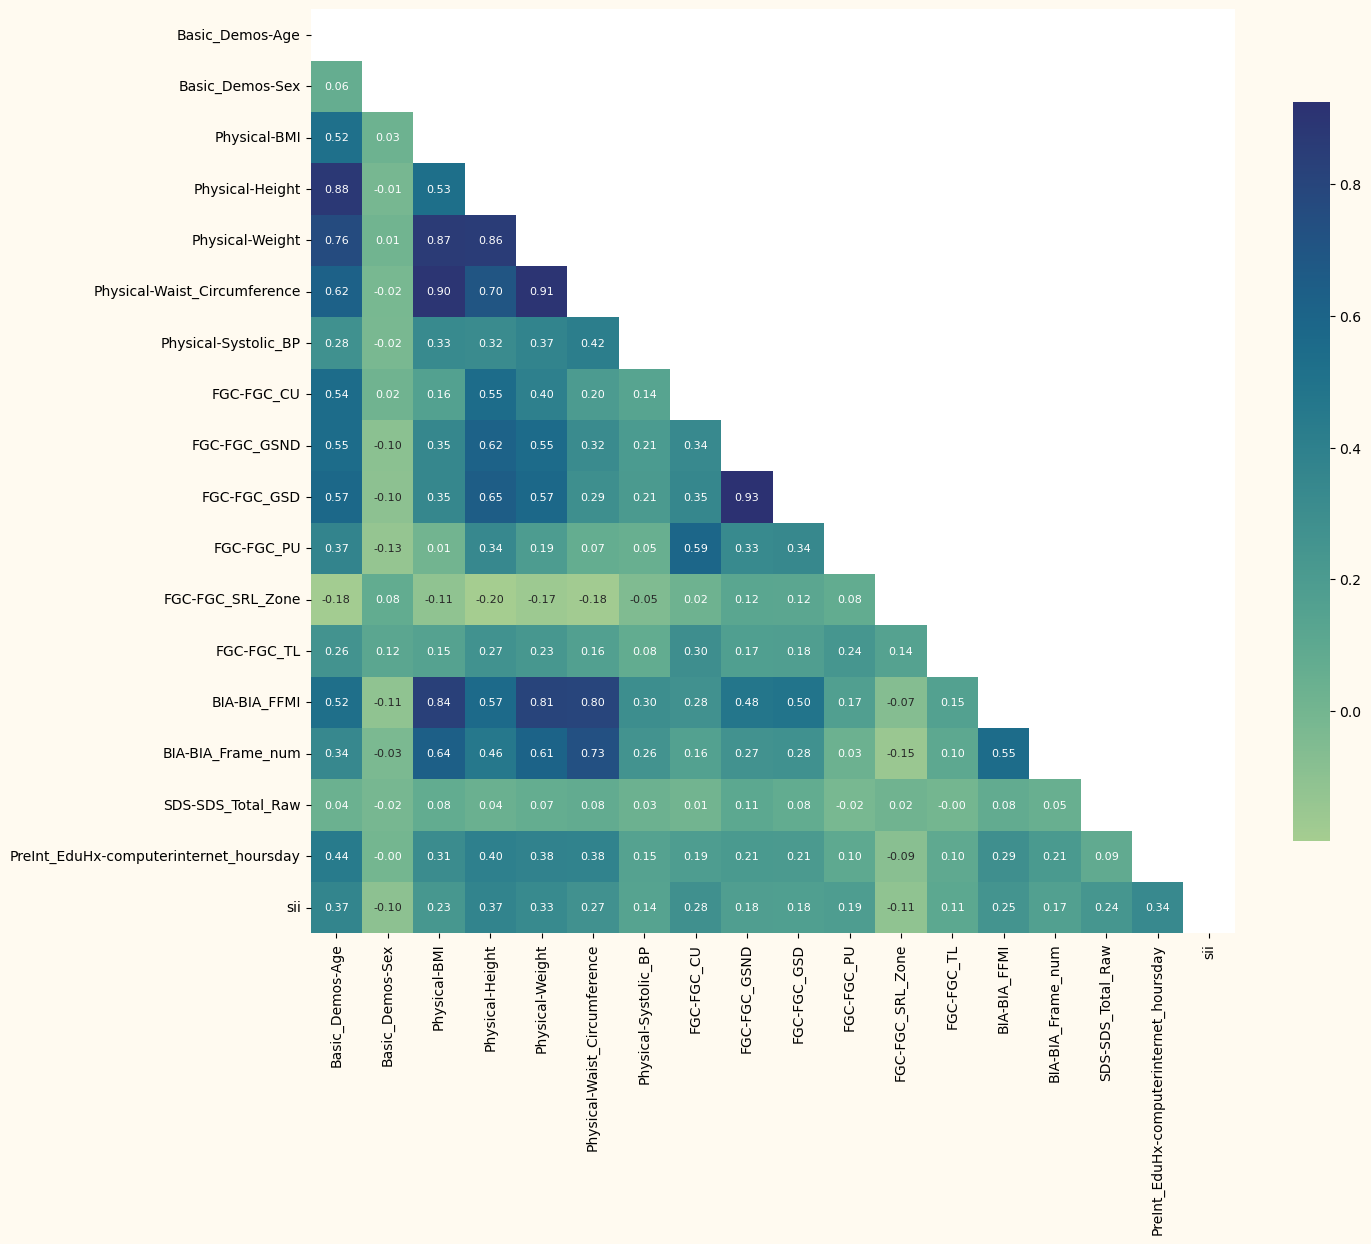

In [ ]:
correlation(train_processed)

<section id="back2"> </section>

<nav style="margin-top: 20px; padding: 10px; border: 10px solid #ccc;">
    <div>
        <h2 style="margin: 0;text-align: center;">Categorical data</h2>
        <br>
         It can be seen that all of the categorical features repreasent the season which the test were performed.
        I investigated to find relationships between them and the target and also used the chi square test in order to find the most significant features out of them. 
    </div>
  <ul style="list-style: none; padding: 0;">
    <li style="margin: 5px 0;"><a href="#preSec" style="text-decoration: none; color: #333;">Dataset Explanation </a></li>

  </ul>
</nav>

In [ ]:
# Create categorical dataframe consist only categorical features
categorical_df = train.select_dtypes(exclude='number')

# Make a categorical dataframe of dummies
categorical_df_dummies= pd.get_dummies(categorical_df)

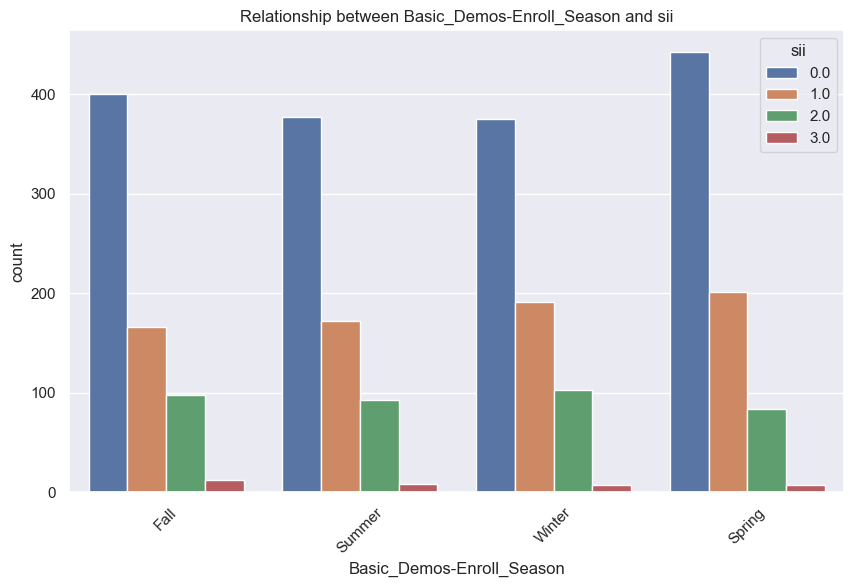

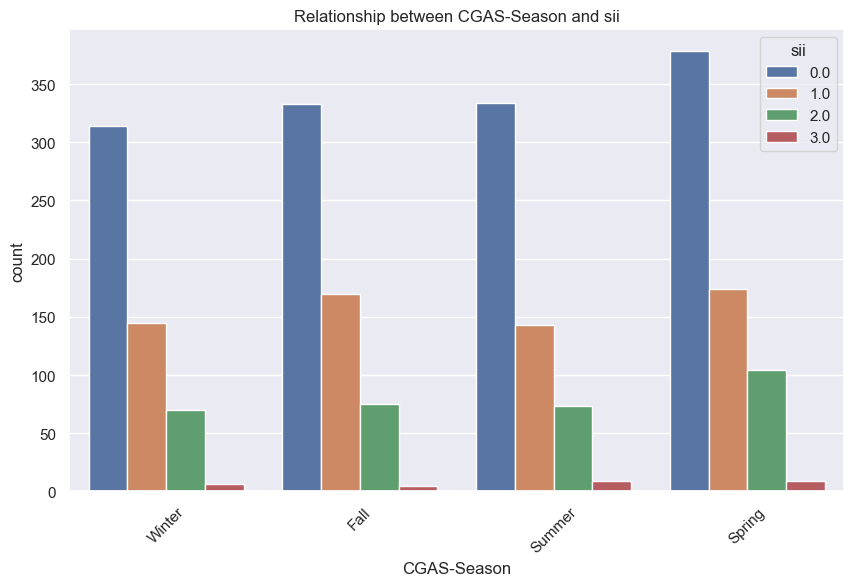

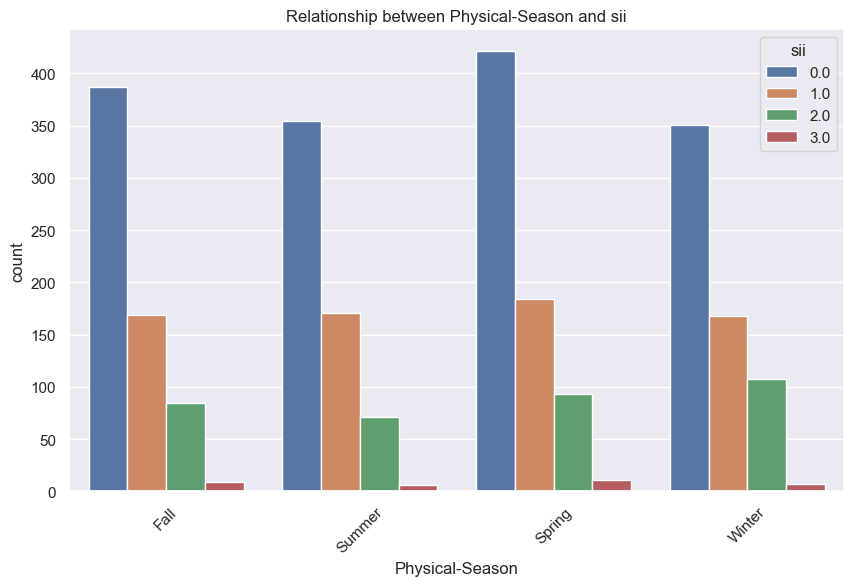

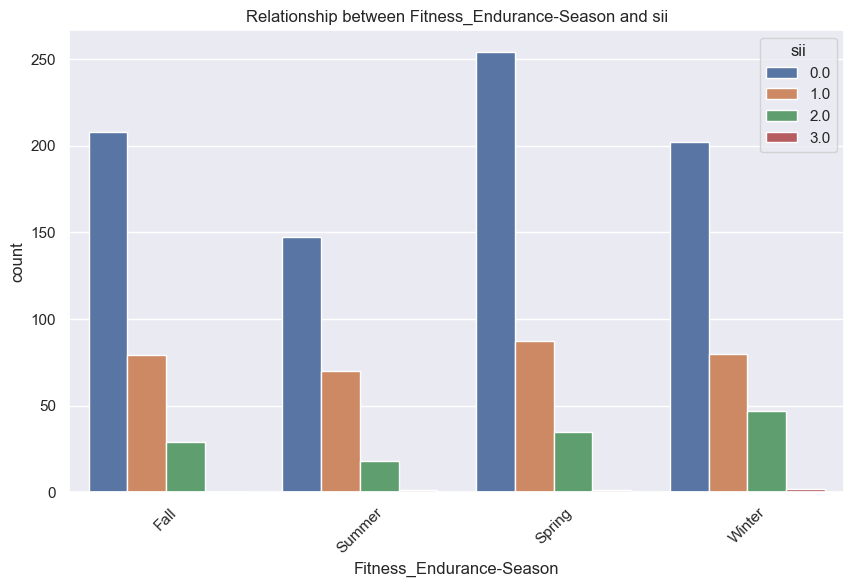

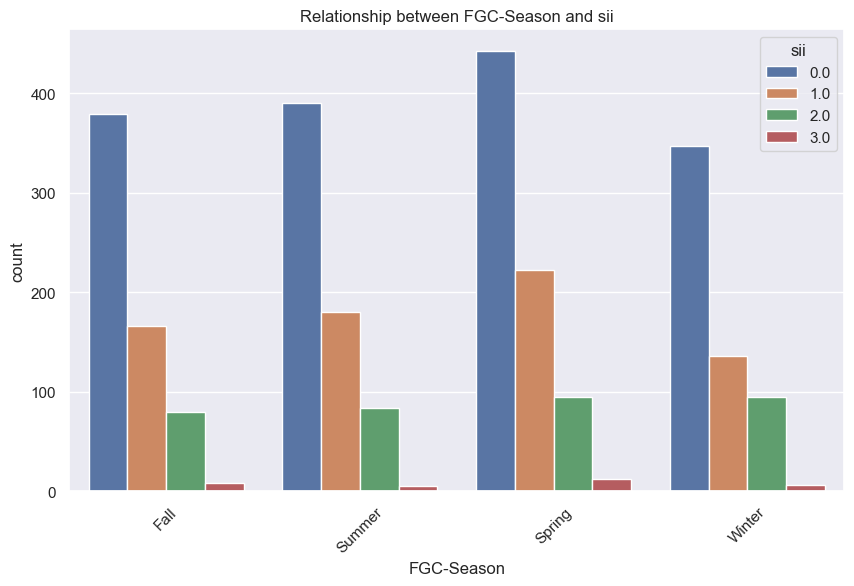

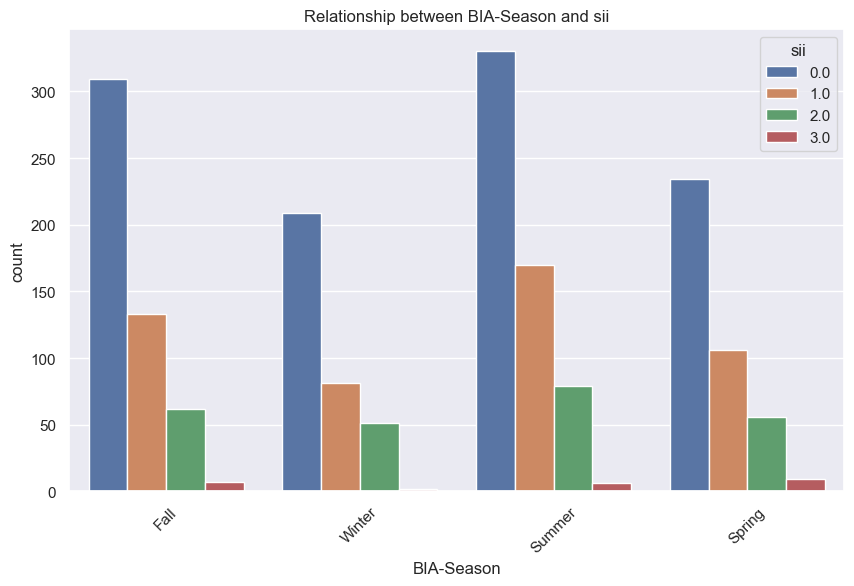

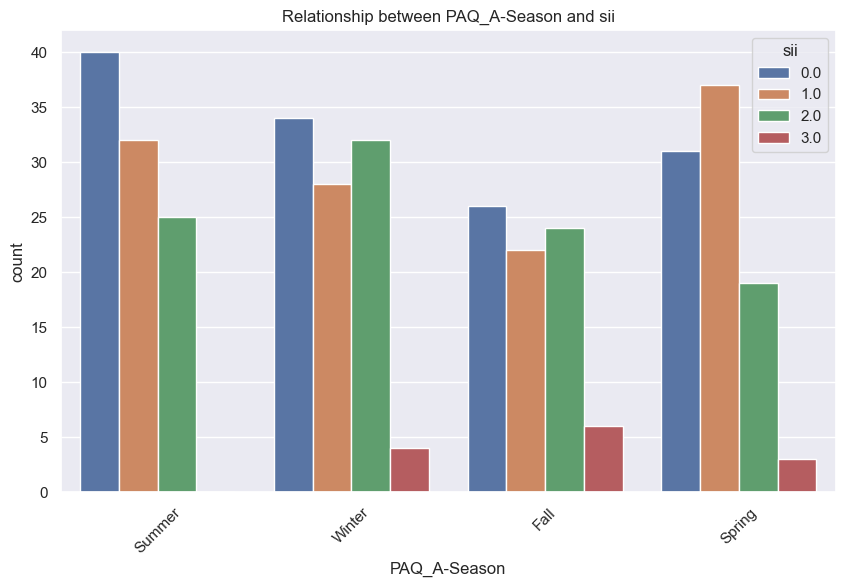

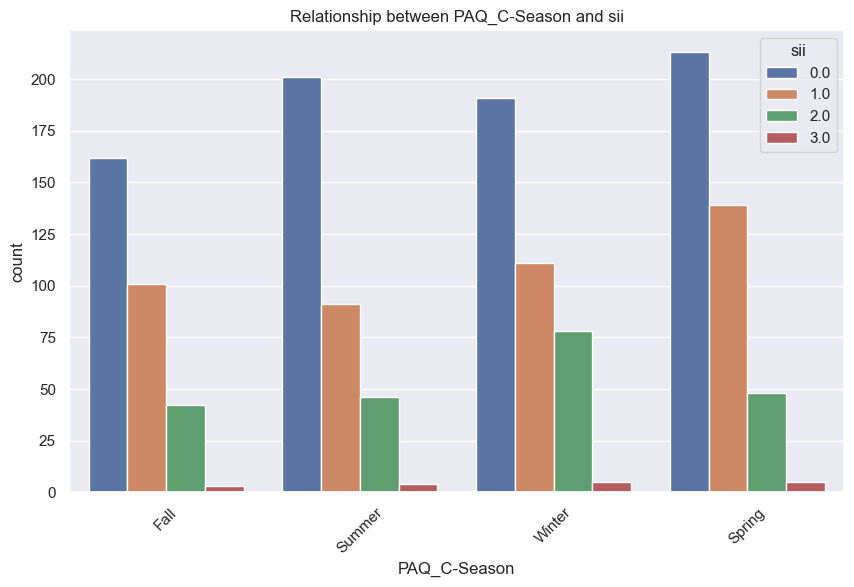

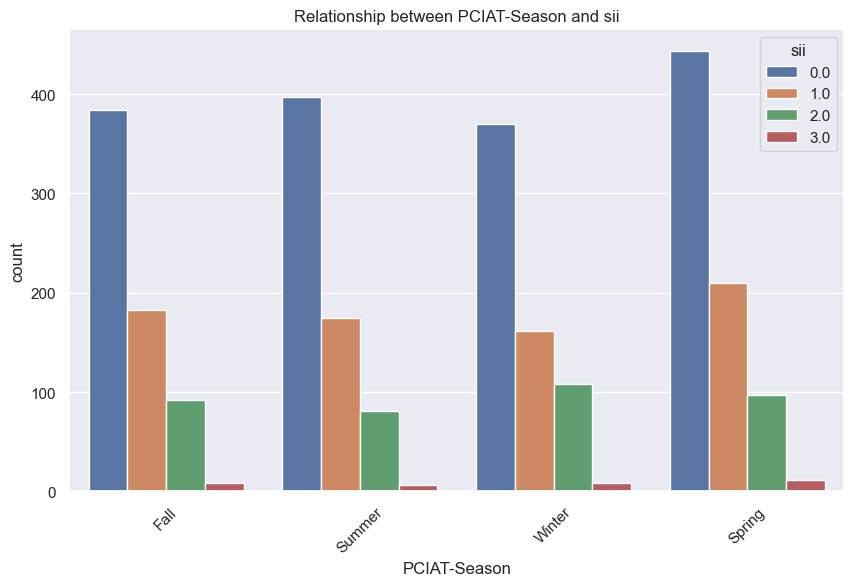

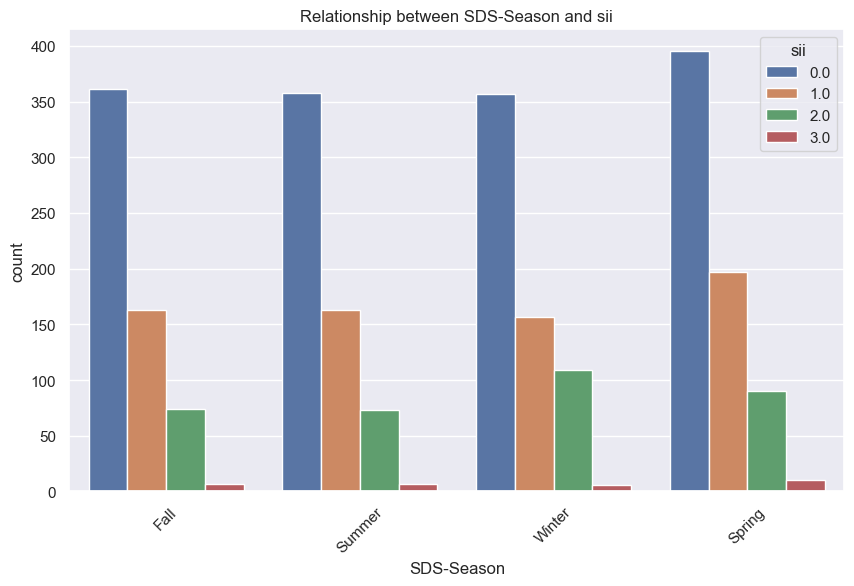

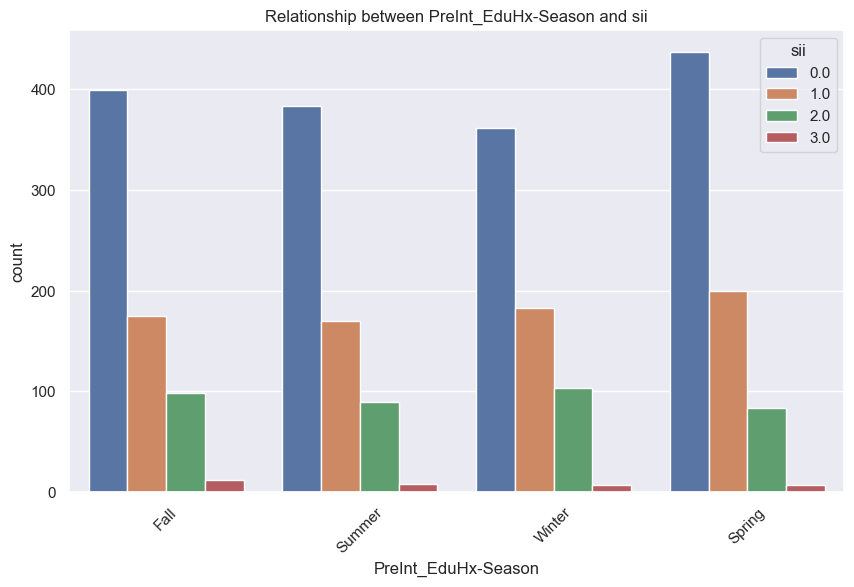

In [ ]:
from sklearn.feature_selection import mutual_info_classif

def visualize_relationships(df, categorical_columns, Target_series):
    for column in categorical_columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=column, hue=Target_series, data=df)
        plt.title(f'Relationship between {column} and {Target_series.name}')
        plt.xticks(rotation=45)
        plt.show()
        
# usage
visualize_relationships(categorical_df, categorical_columns, Target_series)

<h3>Insights</h3>
In PAQ_A Season there seem to be a higher percentage of moderate participants in the winter 

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    if n==1:
        return 0
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def check_multicollinearity(df, categorical_columns):
    n = len(categorical_columns)
    cramer_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            if i != j:
                cramer_matrix[i, j] = cramers_v(df[categorical_columns[i]], df[categorical_columns[j]])
                cramer_matrix[j, i] = cramer_matrix[i, j]
            else:
                cramer_matrix[i, j] = 1.0
    
    cramer_df = pd.DataFrame(cramer_matrix, index=categorical_columns, columns=categorical_columns)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cramer_df, annot=True, cmap='coolwarm')
    plt.title('Multicollinearity Heatmap (Cramer\'s V)')
    plt.tight_layout()
    plt.show()
    
    return cramer_df

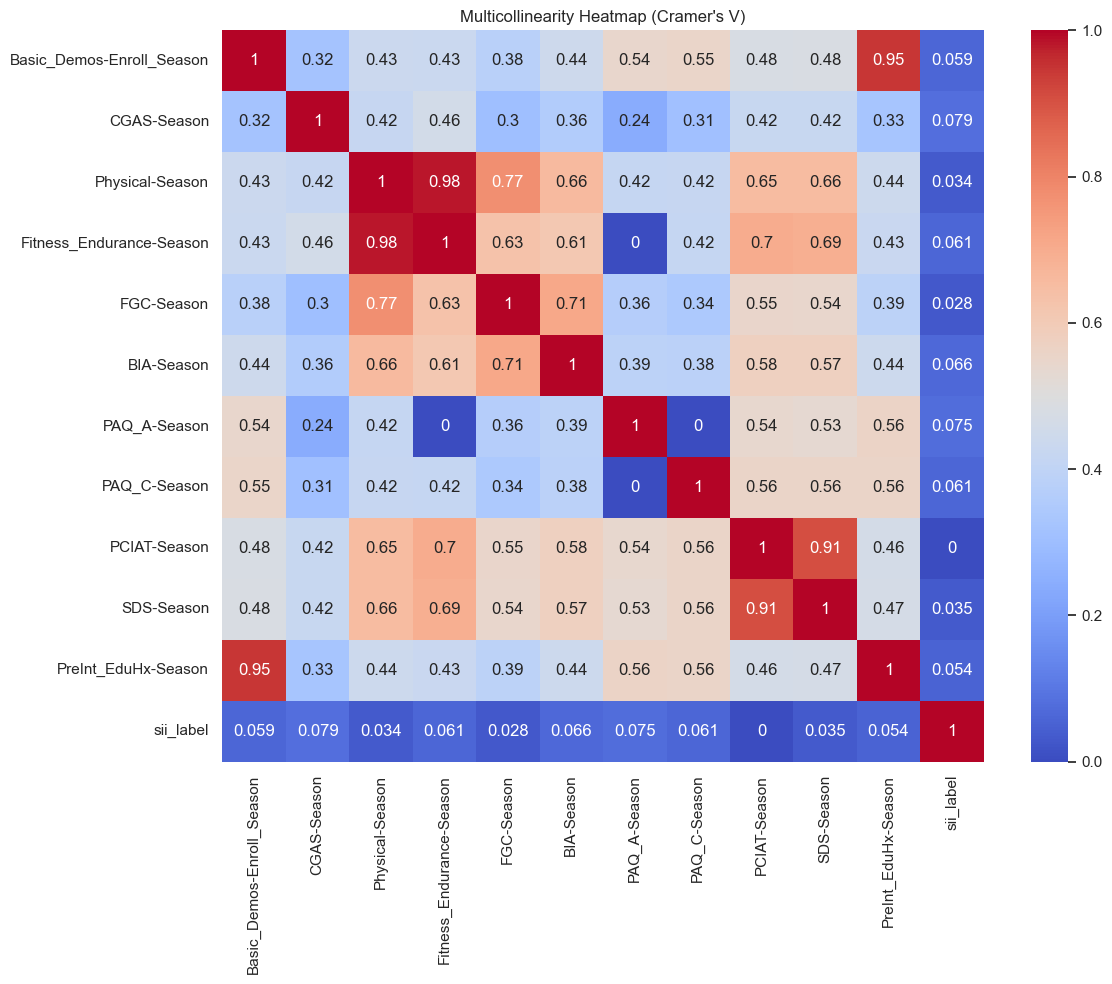

In [ ]:
# Usage
multicollinearity_matrix = check_multicollinearity(mapped_df, mapped_df.select_dtypes(exclude="number").drop('sii_filled',axis=1).columns)

<h3> Insights </h3>
There is multicollinearity between the following pairs in the datasets 

<li>PreInt_EduHx and Basic_Demos-Enroll_Season</li>
<li> Physical-Season and Fitness_Endurance-Season</li>
It can be seen that non of the features corrlate well to the target series.
It might be necessary to try dummies or other methods

In [ ]:
# Investigate highly correlated features
equal_rows = train[train['PreInt_EduHx-Season'] == train['Basic_Demos-Enroll_Season']]
print("Different values: ")
display(len(train['PreInt_EduHx-Season'].dropna())-len(equal_rows))

print("Different values: ")
equal_rows = train[train['Physical-Season'] == train['Fitness_Endurance-Season']]
len(train['Fitness_Endurance-Season'].dropna()) - len(equal_rows)

Different values: 


146

Different values: 


17

In [ ]:
# Drop highly correlated features 
train_missing = train_missing.drop(["Physical-Season","PreInt_EduHx-Season"],axis=1)
train_missing.shape

(3960, 57)

<h3> SelectKBest </h3>
Find the categorical features with the highest chi2 statistical connection to the target 

In [ ]:
categorical_dummies = pd.concat([categorical_df_dummies, Target_series], axis=1).dropna()

# Three features with highest chi-squared statistics are selected
chi2_features = SelectKBest(chi2, k=10)
X_kbest_features = chi2_features.fit_transform(categorical_dummies.drop("sii",axis=1),categorical_dummies["sii"])

feature_names = categorical_dummies.drop("sii", axis=1).columns

scores = chi2_features.scores_

# Create a DataFrame to visualize the results
feature_scores = pd.DataFrame({'Feature': feature_names, 'Score': scores})

# Sort the DataFrame by scores in descending order
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

# Print the top 10 features
print(feature_scores.head(10))
# Reduced features
print('Original feature number:', categorical_df_dummies.shape[1])
print('Reduced feature number:', X_kbest_features.shape[1])

                            Feature      Score
24                PAQ_A-Season_Fall  50.723086
27              PAQ_A-Season_Winter  40.999273
25              PAQ_A-Season_Spring  22.418003
26              PAQ_A-Season_Summer  17.515506
31              PAQ_C-Season_Winter  17.192452
13  Fitness_Endurance-Season_Spring  15.713423
12    Fitness_Endurance-Season_Fall  12.285060
29              PAQ_C-Season_Spring  12.223208
14  Fitness_Endurance-Season_Summer   9.258577
39                SDS-Season_Winter   6.984078
Original feature number: 44
Reduced feature number: 10


PAQ_A-Season_Fall  PAQ_A-Season_Winter  PAQ_A-Season_Spring  \
0                 False                False                False   
1                 False                False                False   
2                 False                False                False   
3                 False                False                False   
4                 False                False                False   
...                 ...                  ...                  ...   
3955              False                False                False   
3956              False                False                False   
3957              False                False                False   
3958              False                False                False   
3959              False                False                False   

      PAQ_A-Season_Summer  PAQ_C-Season_Winter  \
0                   False                False   
1                   False                False   
2                   False                False   
3                   False                 True   
4                    True                False   
...                   ...                  ...   
3955                False                 True   
3956                False                 True   
3957                False                 True   
3958                False                False   
3959                False                False   

      Fitness_Endurance-Season_Spring  Fitness_Endurance-Season_Fall  \
0                               False                          False   
1                               False                          False   
2                               False                           True   
3                               False                          False   
4                               False                          False   
...                               ...                            ...   
3955                            False                          False   
3956                            False                          False   
3957                            False                          False   
3958                            False                          False   
3959                            False                          False   

      PAQ_C-Season_Spring  Fitness_Endurance-Season_Summer  SDS-Season_Winter  \
0                   False                            False              False   
1                   False                            False              False   
2                   False                            False              False   
3                   False                             True              False   
4                   False                            False              False   
...                   ...                              ...                ...   
3955                False                            False               True   
3956                False                            False              False   
3957                False                            False               True   
3958                 True                            False              False   
3959                False                            False              False   

         sii_label  
0         Moderate  
1             None  
2             None  
3             Mild  
4     Missing Data  
...            ...  
3955          Mild  
3956  Missing Data  
3957          Mild  
3958          None  
3959  Missing Data  

[3960 rows x 11 columns]

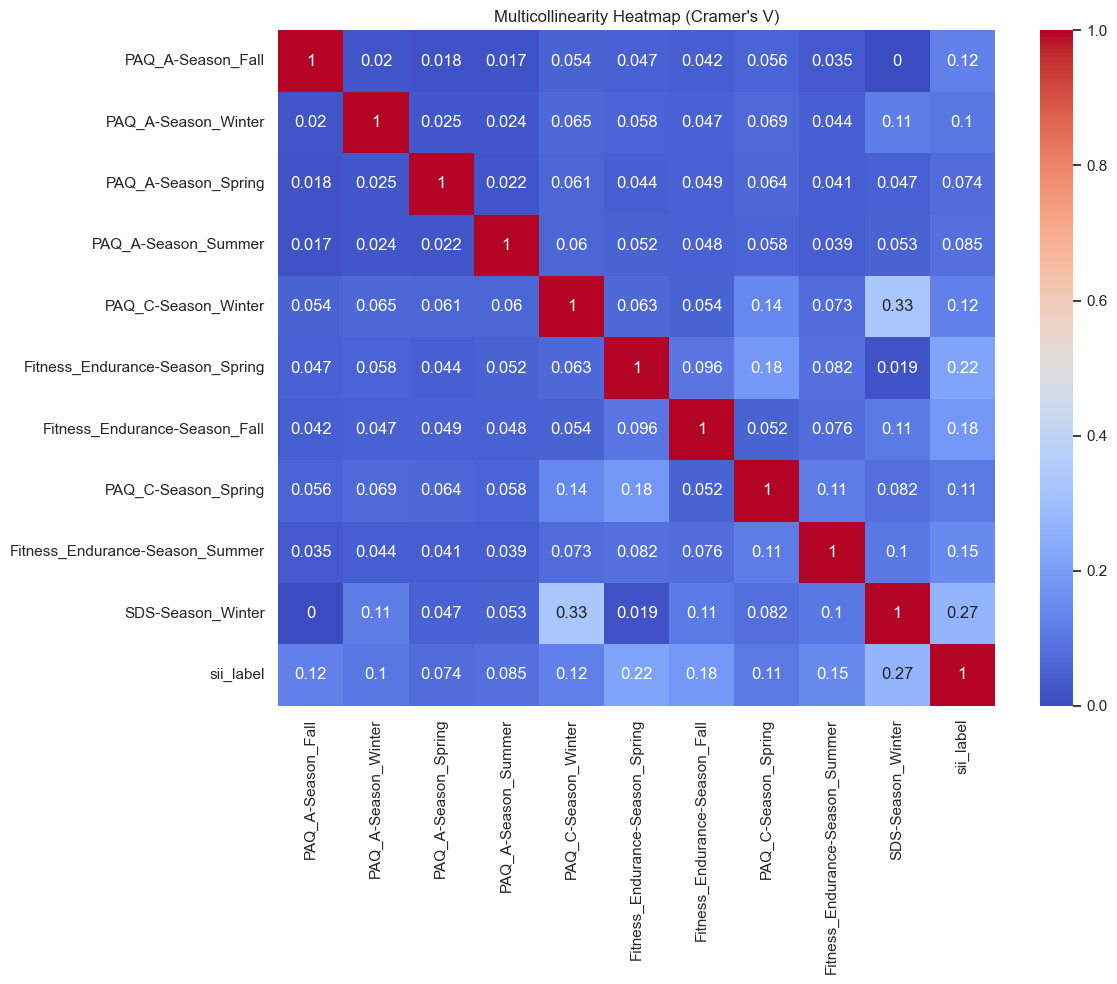

In [ ]:
# Combine categorical features with the numerical train set 
Kbest_cols=[]
Kbest_cols = list(feature_scores.iloc[:10]["Feature"].unique())
categorical_df_dummies = categorical_df_dummies[Kbest_cols]

categorical_df_dummies = concat_df_a_target(categorical_df_dummies, mapped_df["sii_label"])
display(categorical_df_dummies)

multicollinearity_matrix = check_multicollinearity(categorical_df_dummies, categorical_df_dummies.columns)

<h3> Insights </h3>
It can be seen that the dummies data perform much better then the original even reaching almost 0.3 correlation (which indicated a medium strength correlation).
Due to the great results I will run the Cramer's V function on all the data to see if I missed another significant features 

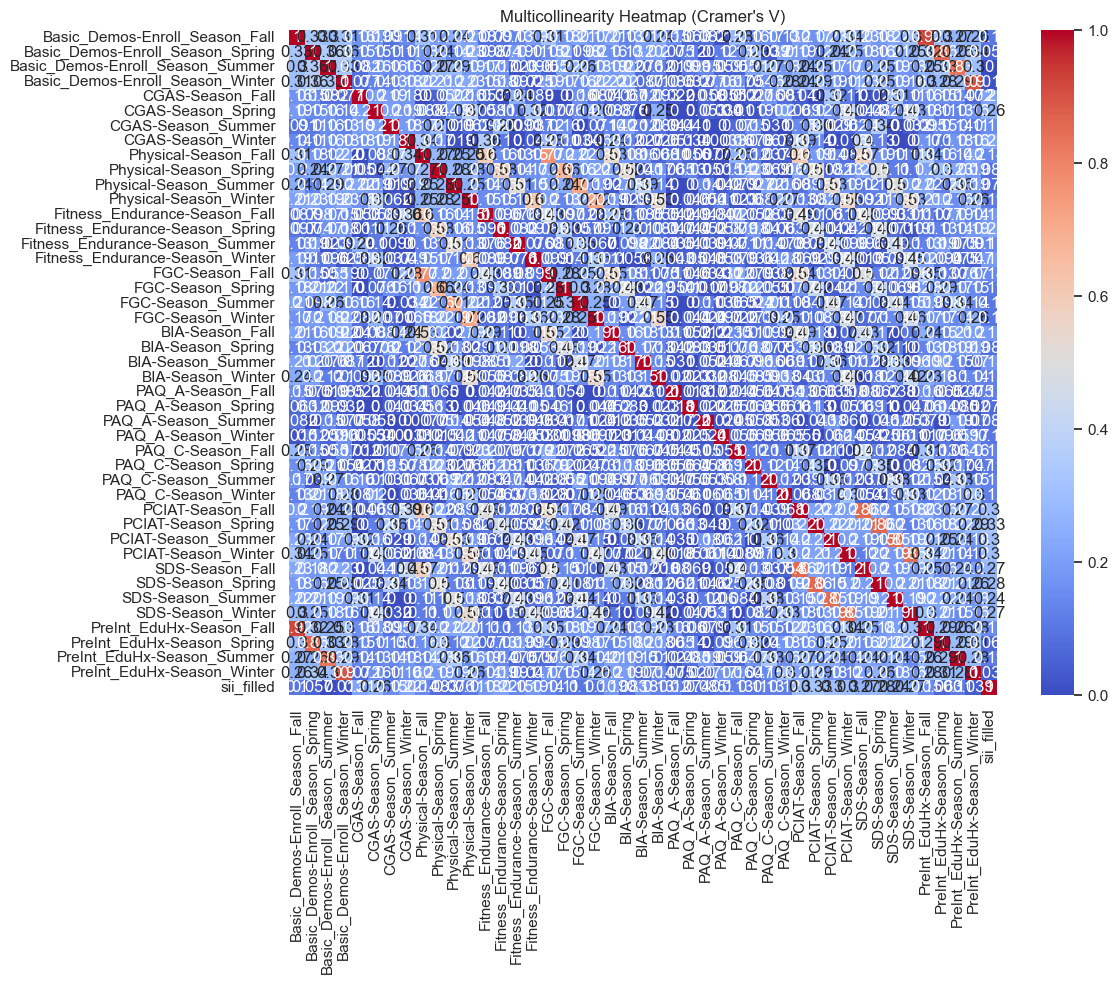

SDS-Season_Spring                  0.284139
SDS-Season_Winter                  0.266745
SDS-Season_Fall                    0.266048
CGAS-Season_Spring                 0.262903
SDS-Season_Summer                  0.240847
CGAS-Season_Winter                 0.221547
Fitness_Endurance-Season_Spring    0.217139
CGAS-Season_Fall                   0.214904
Fitness_Endurance-Season_Winter    0.190407
BIA-Season_Fall                    0.185036
Name: sii_filled, dtype: float64

In [ ]:
categorical_df_dummies_1= pd.get_dummies(categorical_df)
categorical_df_dummies_1 = concat_df_a_target(categorical_df_dummies_1, mapped_df["sii_filled"])
multicollinearity_matrix = check_multicollinearity(categorical_df_dummies_1, categorical_df_dummies_1.columns)
multicollinearity_matrix["sii_filled"].sort_values(ascending=False)[5:15]

<h3> Insights </h3>
The 10 features we got now seem to consistently have stronger relationships then the first 10 features. It should be checked which subset of features performs better in terms of final results

<h2>Combine sets</h2>
Combine the categrocial features dataset with the numerical features dataset

<h3> Export </h3>
export the processed files of the train and test sets 

In [ ]:
# First version dataframe with only numeric values with high correlation
train_processed.to_csv("../data/processed/train_processed.csv", index=False)
test_processed.to_csv("../data/processed/test_processed.csv", index=False)